### Project Overview

**Problem:** ConnectTel is experiencing a significant issue with customer churn, which is the tendency of customers to discontinue their service with the company. This problem affects the company's revenue and growth. The aim is to develop a robust customer churn prediction system using advanced analytics and machine learning techniques to forecast which customers are likely to churn and implement targeted retention strategies.

**Target Variable:** The target variable for customer churn analysis is Churn, which indicates whether a customer has cancelled their service **(Yes)** or not **(No)**.

This project builds a binary classification model to predict customer churn using supervised machine learning, compares multiple classification models to address class imbalance in the dataset, tunes the best-performing model, and optimises the classification threshold. The final trained pipeline is saved for deployment. The primary evaluation metrics considered were ROC-AUC, Precision-Recall AUC and the F1-score.

**Note:** The positive class (Churn = 1) represents customers who left.

### Load Libraries

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from collections import Counter

# Sklearn
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, auc, f1_score
)

# Imbalanced learning
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Persisting
import json
from joblib import dump, load
from pathlib import Path


# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

### Data Loading & Initial Cleaning

In [4]:
# define data path
data = 'Customer-Churn.csv'

In [5]:
# load dataset
cs_data = pd.read_csv(data, sep=',', na_values=['nan', 'NaN', 'NA', ' '], keep_default_na=False)

In [6]:
# check columns and rows
cs_data.shape

(7043, 21)

In [7]:
cs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
cs_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Inspect Missing Values

In [9]:
# Check for missing value
cs_data.isnull().sum().sort_values(ascending=False)

TotalCharges        11
customerID           0
DeviceProtection     0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
OnlineBackup         0
gender               0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
SeniorCitizen        0
Churn                0
dtype: int64

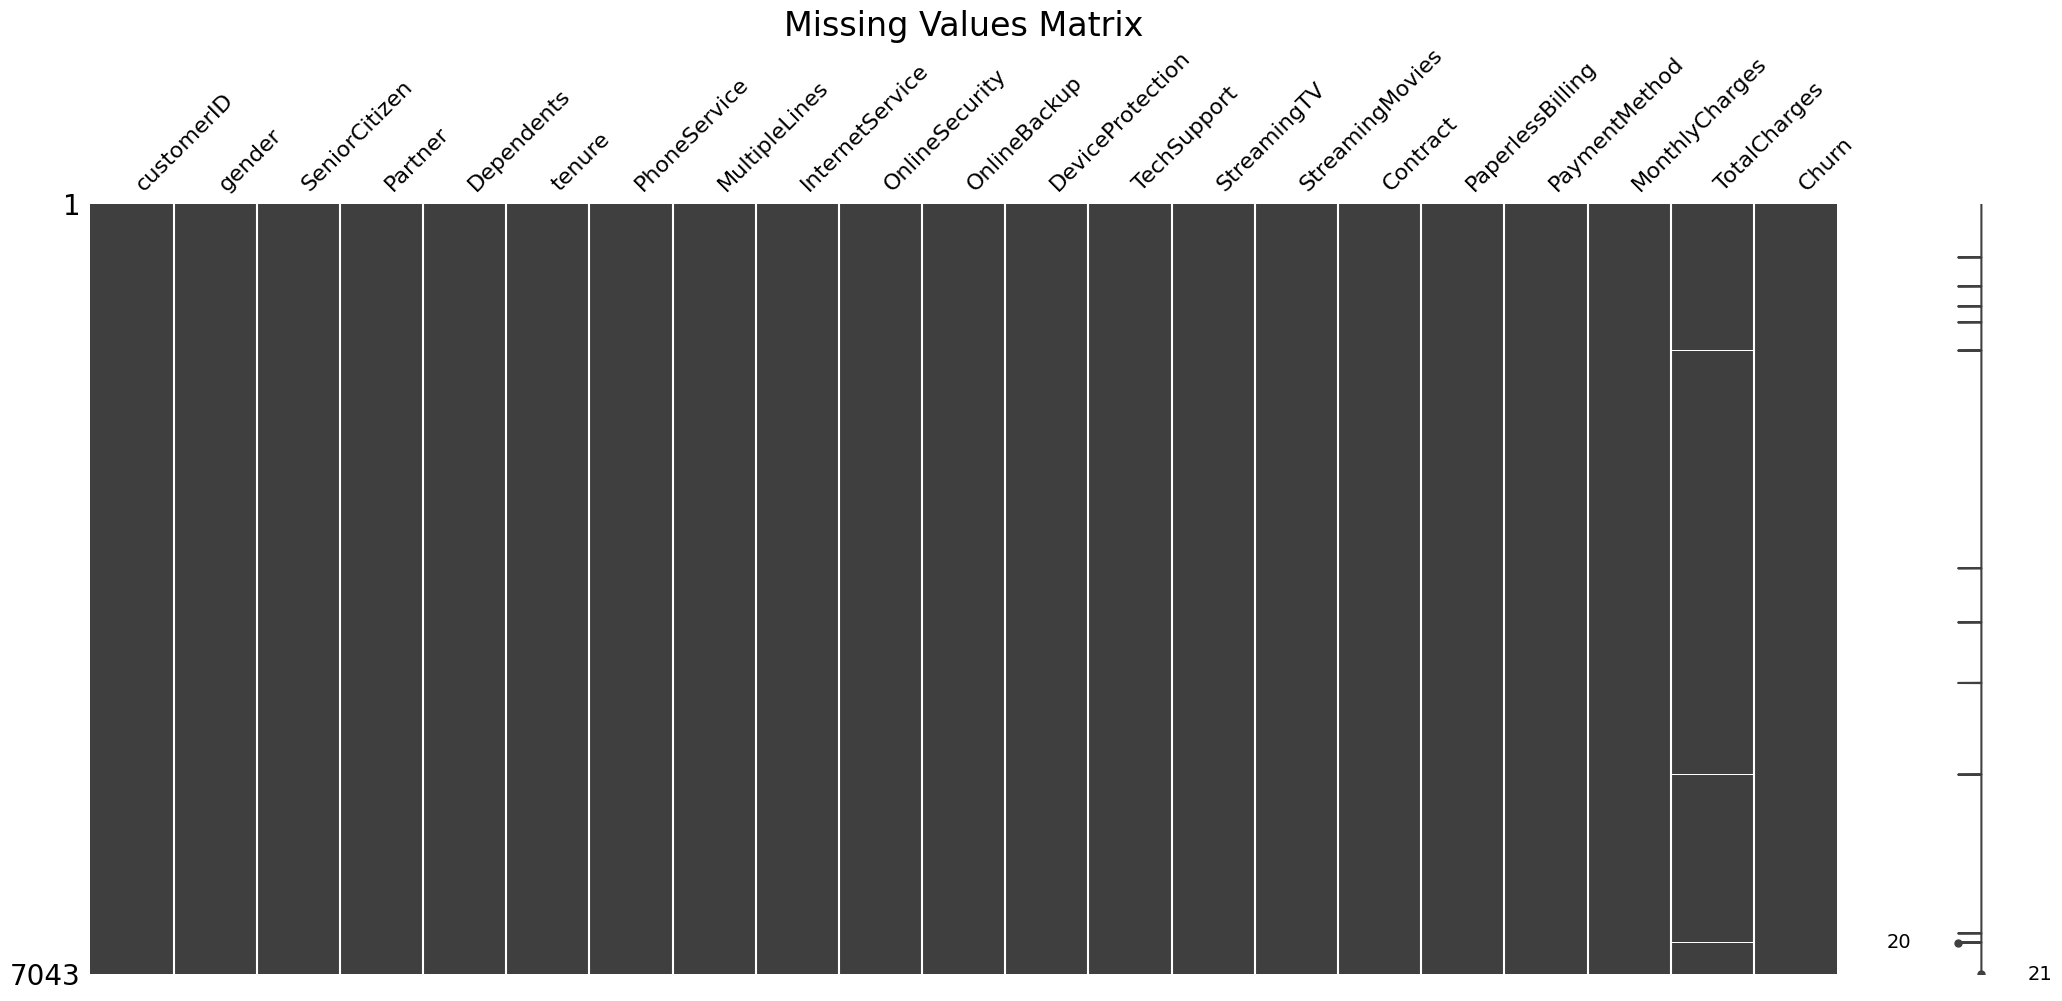

In [10]:
# Visualise the missing values
msno.matrix(cs_data).set_title('Missing Values Matrix', fontsize=24);

In [11]:
# Analysis rows with missing values
imputation_filter = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
rows_with_missing_data = cs_data[cs_data.isna().any(axis=1)]
rows_with_missing_data[imputation_filter]

tenure  MonthlyCharges  TotalCharges Churn
488        0           52.55           NaN    No
753        0           20.25           NaN    No
936        0           80.85           NaN    No
1082       0           25.75           NaN    No
1340       0           56.05           NaN    No
3331       0           19.85           NaN    No
3826       0           25.35           NaN    No
4380       0           20.00           NaN    No
5218       0           19.70           NaN    No
6670       0           73.35           NaN    No
6754       0           61.90           NaN    No

In [13]:
# impute missing values
cs_data.loc[cs_data['tenure'] == 0, 'TotalCharges'] = 0.0

# sanity check
cs_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Overview of the Dataset

The raw dataset consists of 7043 observations (rows) and 21 features (columns/variables). Each observation represents a customer and their associated details, which include:

- **Demographic Information:** (customerID, gender, SeniorCitizen, Partner and Dependents)
- **Account Information:** (tenure, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges and TotalCharges)
- **Service Information**: (PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV and StreamingMovies), and
- **Churn Information**: (Churn)


### Data Loading & Initial Cleaning
The dataset was loaded, and basic cleaning was applied. Additionally, the CustomerID feature was dropped because it did not add predictive value to the analysis, and the target variable Churn was encoded as a binary variable. A summary of the data types shows 16 categorical variables and 4 numerical variables.

#### There are 11 blank values in the TotalCharges variable in the dataset.

These missing values occur for customers with a tenure of zero months. So, instead of dropping the rows, the missing TotalCharges values were imputed by assigning a value of 0 where tenure equals 0, as customers with no tenure have not yet accumulated any charges. 

**Note:** All final imputations are handled inside the ML pipeline to prevent data leakage.

### Feature Engineering

In [15]:
# drop column
cs_data = cs_data.drop('customerID', axis=1)
cs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [16]:
# rename values in the payment method variable
cs_data['PaymentMethod'] = cs_data['PaymentMethod'].replace(
    ['Credit card (automatic)', 'Bank transfer (automatic)'], 
    ['Credit card', 'Bank transfer']
)
cs_data[['PaymentMethod']].loc[3:8]

PaymentMethod
3     Bank transfer
4  Electronic check
5  Electronic check
6       Credit card
7      Mailed check
8  Electronic check

In [17]:
# Create Total Services Feature - Define the services columns
service_columns = cs_data[[
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]]

# Write a function to count total services, including internet services (DSL and Fiber optic services)
def total_services(row):
    # define container variables for count
    count_yes = 0
    count_dsl = 0
    count_fiber = 0
    # loop through service columns
    for column in service_columns:
        if row[column] == 'Yes':
            count_yes += 1
    # loop through internet services column        
    if row['InternetService'] == 'DSL':
        count_dsl += 1
        
    if row['InternetService'] == 'Fiber optic':
        count_fiber += 1
    # return and sum counts    
    return count_yes + count_dsl + count_fiber

# Apply the function to create the new feature
cs_data['TotalServices'] = cs_data.apply(total_services, axis=1)

cs_data[[
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'TotalServices'
]].loc[4:11]

PhoneService     MultipleLines InternetService       OnlineSecurity  \
4           Yes                No     Fiber optic                   No   
5           Yes               Yes     Fiber optic                   No   
6           Yes               Yes     Fiber optic                   No   
7            No  No phone service             DSL                  Yes   
8           Yes               Yes     Fiber optic                   No   
9           Yes                No             DSL                  Yes   
10          Yes                No             DSL                  Yes   
11          Yes                No              No  No internet service   

           OnlineBackup     DeviceProtection          TechSupport  \
4                    No                   No                   No   
5                    No                  Yes                   No   
6                   Yes                   No                   No   
7                    No                   No                   No   
8                    No                  Yes                  Yes   
9                   Yes                   No                   No   
10                   No                   No                   No   
11  No internet service  No internet service  No internet service   

            StreamingTV      StreamingMovies  TotalServices  
4                    No                   No              2  
5                   Yes                  Yes              6  
6                   Yes                   No              5  
7                    No                   No              2  
8                   Yes                  Yes              7  
9                    No                   No              4  
10                   No                   No              3  
11  No internet service  No internet service              1

In [18]:
# Create a new feature to categorise the SeniorCitizen column using lambda function
cs_data['SeniorCitizenCat'] = cs_data['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')
# Display rows from 21 to 30
cs_data[['SeniorCitizen', 'SeniorCitizenCat']].iloc[30:35]

SeniorCitizen SeniorCitizenCat
30              1              Yes
31              1              Yes
32              0               No
33              0               No
34              1              Yes

In [19]:
# drop the senior citizens
cs_data = cs_data.drop(['SeniorCitizen'], axis=1)

In [20]:
eda_data = cs_data.copy()
eda_data.head(2)

gender Partner Dependents  tenure PhoneService     MultipleLines  \
0  Female     Yes         No       1           No  No phone service   
1    Male      No         No      34          Yes                No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection  ...  \
0             DSL             No          Yes               No  ...   
1             DSL            Yes           No              Yes  ...   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   

      PaymentMethod MonthlyCharges  TotalCharges  Churn TotalServices  \
0  Electronic check          29.85         29.85     No             2   
1      Mailed check          56.95       1889.50     No             4   

   SeniorCitizenCat  
0                No  
1                No  

[2 rows x 21 columns]

### Create churn label

In [21]:
# Define churn label and encode the label
cs_data["y"] = cs_data["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# sanity check
cs_data[["Churn", "y"]].head()

Churn  y
0    No  0
1    No  0
2   Yes  1
3    No  0
4   Yes  1

### Feature Engineering
Two new features were created:
- TotalServices: Counts the number of subscribed services per customer, and
- SeniorCitizenCat: Creates a categorical version of the SeniorCitizen flag for modeling consistency.

Feature selection for modeling is based on EDA relevance and business intuition.

### Exploratory Data Analysis (EDA)

### Summary Statistics

In [22]:
# Summary statistics for numerical columns
eda_data.describe()

tenure  MonthlyCharges  TotalCharges  TotalServices
count  7043.000000     7043.000000   7043.000000    7043.000000
mean     32.371149       64.761692   2279.734304       4.146244
std      24.559481       30.090047   2266.794470       2.312720
min       0.000000       18.250000      0.000000       1.000000
25%       9.000000       35.500000    398.550000       2.000000
50%      29.000000       70.350000   1394.550000       4.000000
75%      55.000000       89.850000   3786.600000       6.000000
max      72.000000      118.750000   8684.800000       9.000000

### Summary Statistics for Numerical Columns

Out of 7032 customers, only 16.24% are senior citizens, indicating a skew towards younger or middle-aged customers. Customer tenure ranges from 1 to 72 months, with an average of 32 months and a median of 29 months, reflecting varied loyalty. Monthly charges range from 18.25 to 118.75, averaging 64.80 and a median of 70.35. Total charges vary from 18.80 to 8684.80, with an average of 2283.30 and a median of 1397.48. 

**These figures highlight significant variability in customer retention, monthly billing, and accumulated charges, influenced by differing service plans and usage patterns.**

In [23]:
# Summary statistics for categorical columns
cat_sum_stats = eda_data.describe(include=['object'])
cat_sum_stats

gender Partner Dependents PhoneService MultipleLines InternetService  \
count    7043    7043       7043         7043          7043            7043   
unique      2       2          2            2             3               3   
top      Male      No         No          Yes            No     Fiber optic   
freq     3555    3641       4933         6361          3390            3096   

       OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
count            7043         7043             7043        7043        7043   
unique              3            3                3           3           3   
top                No           No               No          No          No   
freq             3498         3088             3095        3473        2810   

       StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
count             7043            7043             7043              7043   
unique               3               3                2                 4   
top                 No  Month-to-month              Yes  Electronic check   
freq              2785            3875             4171              2365   

       Churn SeniorCitizenCat  
count   7043             7043  
unique     2                2  
top       No               No  
freq    5174             5901

### Summary Statistics for Categorical Variables
There is a balanced gender distribution, with males slightly higher by 1%. About 52% of customers are single, and nearly 70% do not have dependents. Phone service is nearly universal at 90%, though 48% do not have multiple lines. Fiber optic internet is preferred by 44% of customers. Many do not use additional services like online security (50%) and streaming (around 2,800 customers each). Most customers (3,875) prefer month-to-month contracts, and 4,168 opt for paperless billing. Electronic check is the most popular payment method. A low churn rate with 5,163 customers indicates high satisfaction and loyalty.

## Data Visualisation

In [24]:
# extract numerical and categorical columns from the dataframe
categorical_columns = eda_data.select_dtypes(include=['object']).columns
numerical_columns = eda_data.select_dtypes(include=['int64', 'float64']).columns

numerical_columns, categorical_columns

(Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices'], dtype='object'),
 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizenCat'],
       dtype='object'))

#### Univariate Analysis (Categorical Variables)

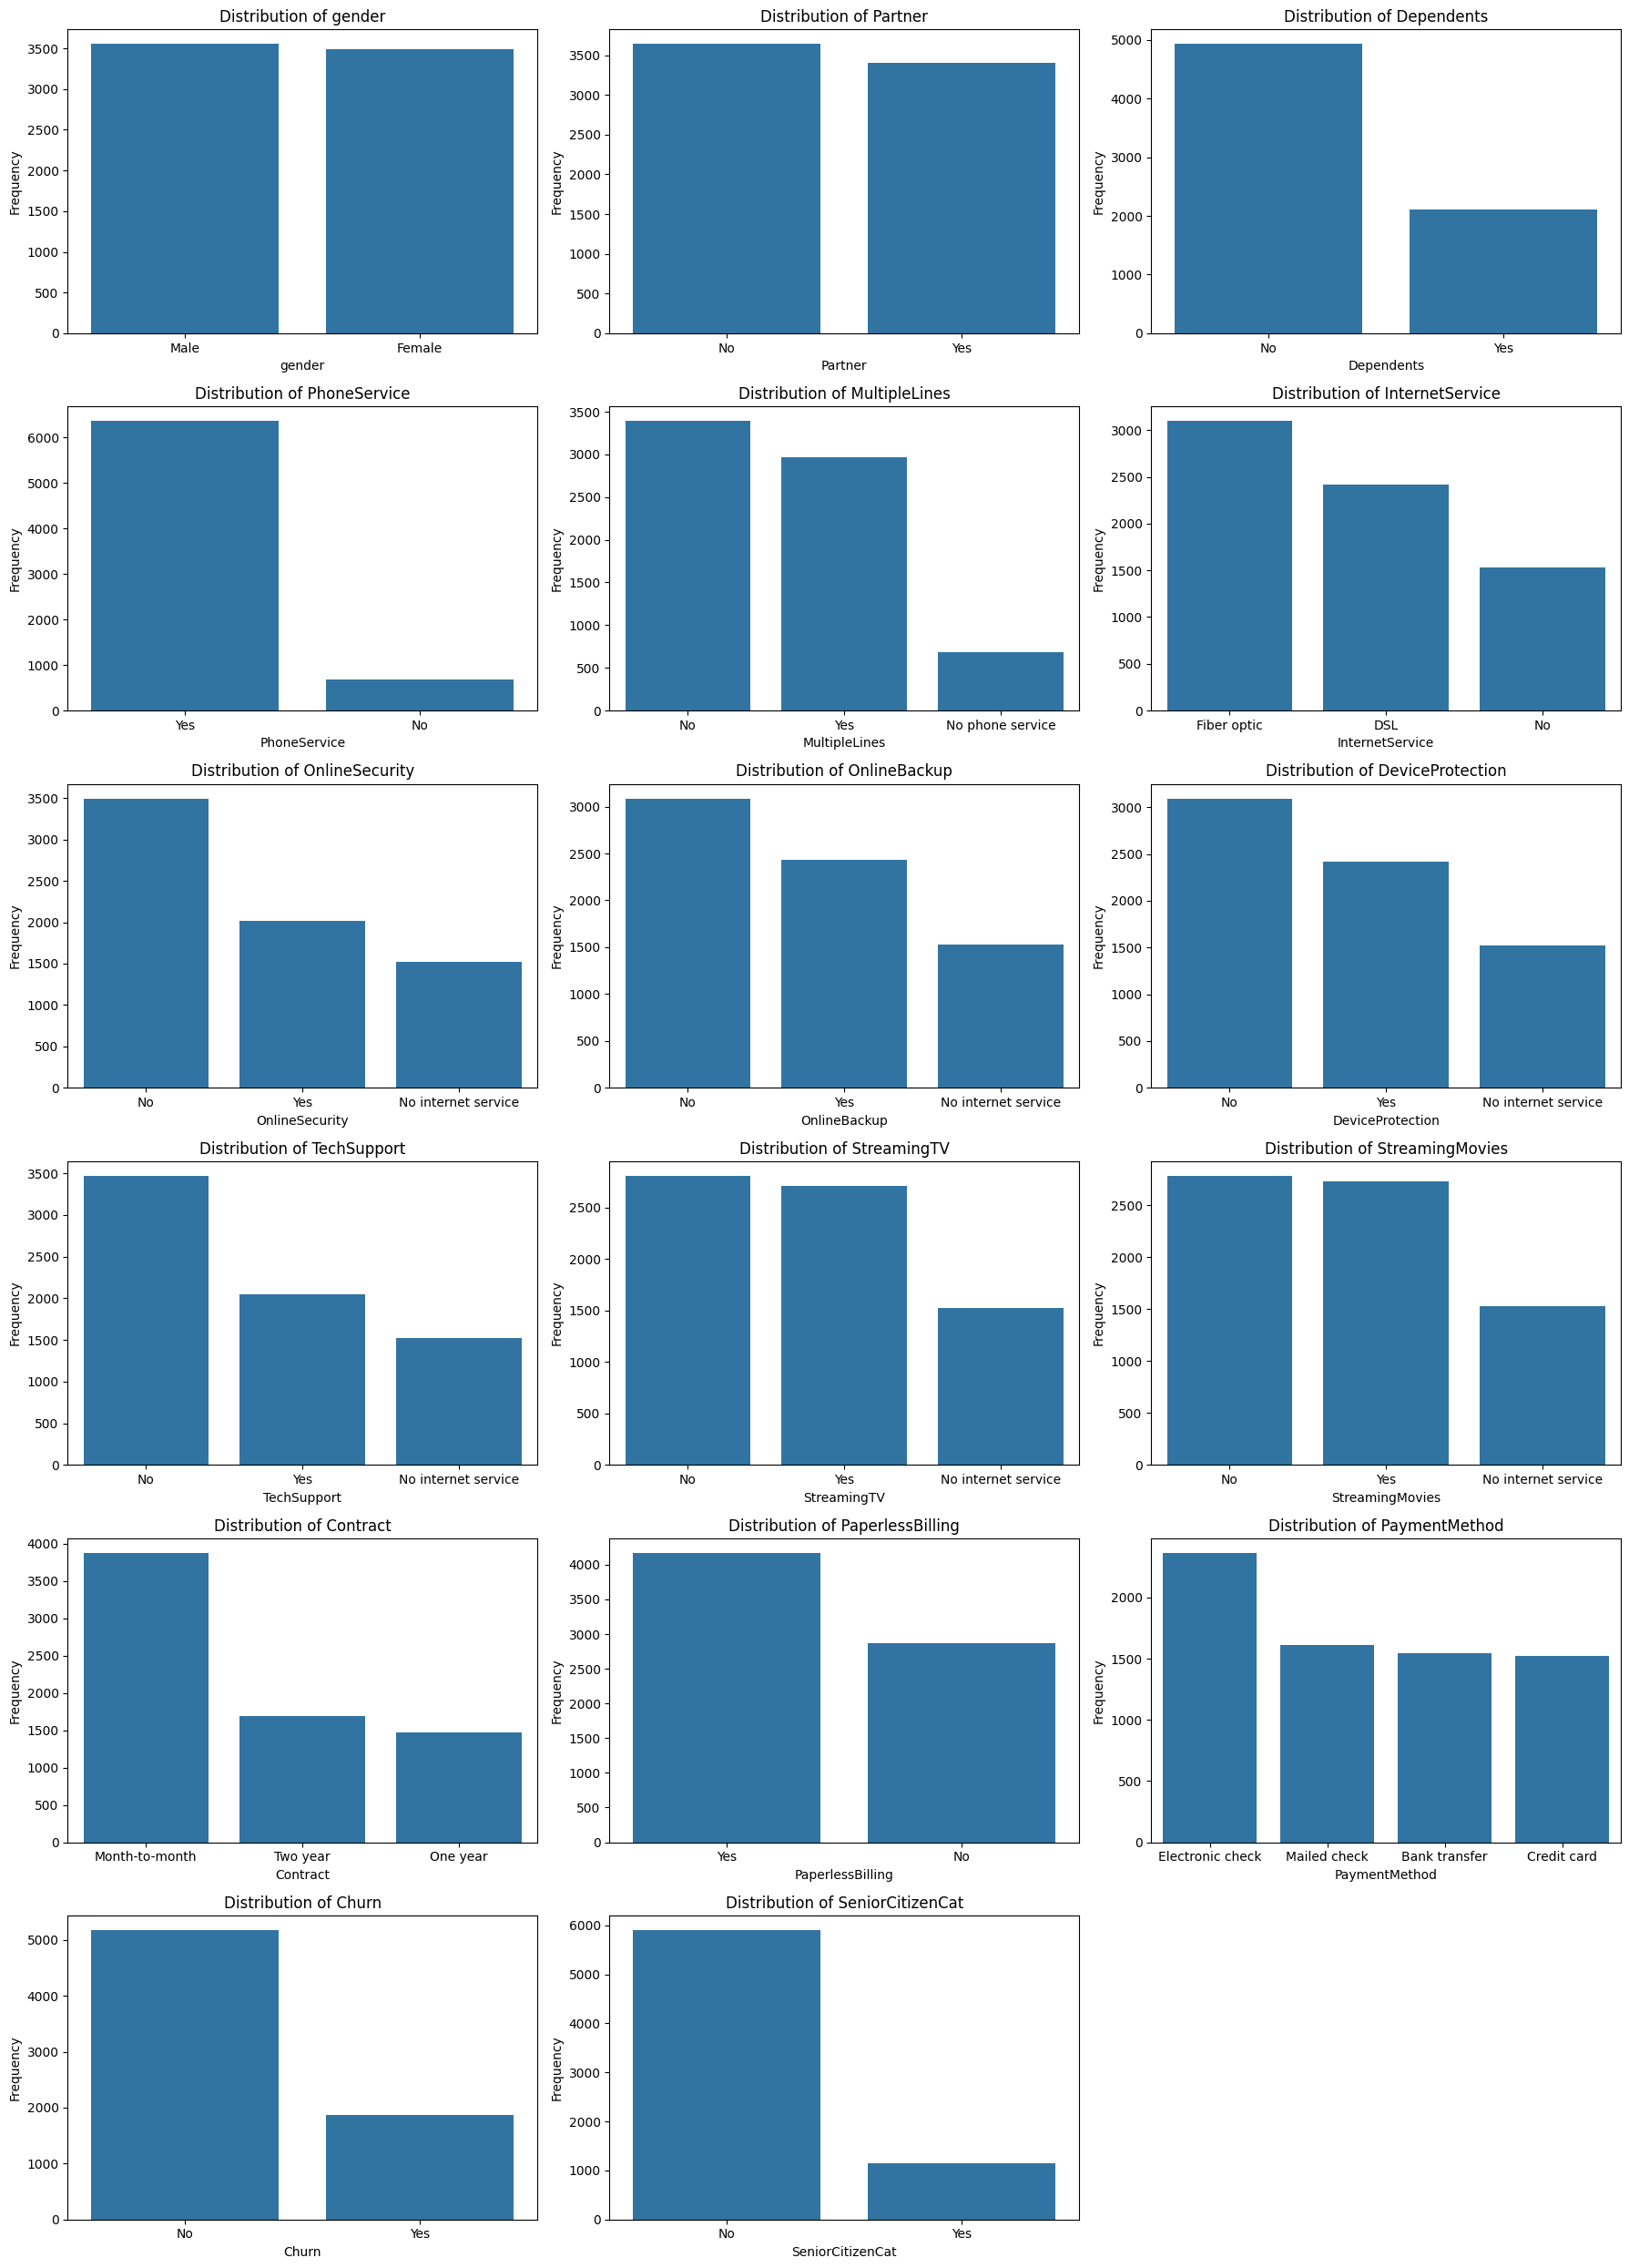

In [25]:
# Univariate analysis for categorical variables
plt.figure(figsize=(18,25)) # define figure size

for i, col in enumerate(eda_data[categorical_columns], 1):
    if col in categorical_columns:
        plt.subplot(6, 3, i)
        sns.countplot(x=col, data=eda_data[categorical_columns], order=eda_data[categorical_columns][col].value_counts().index)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Univariate analysis (numerical variables)

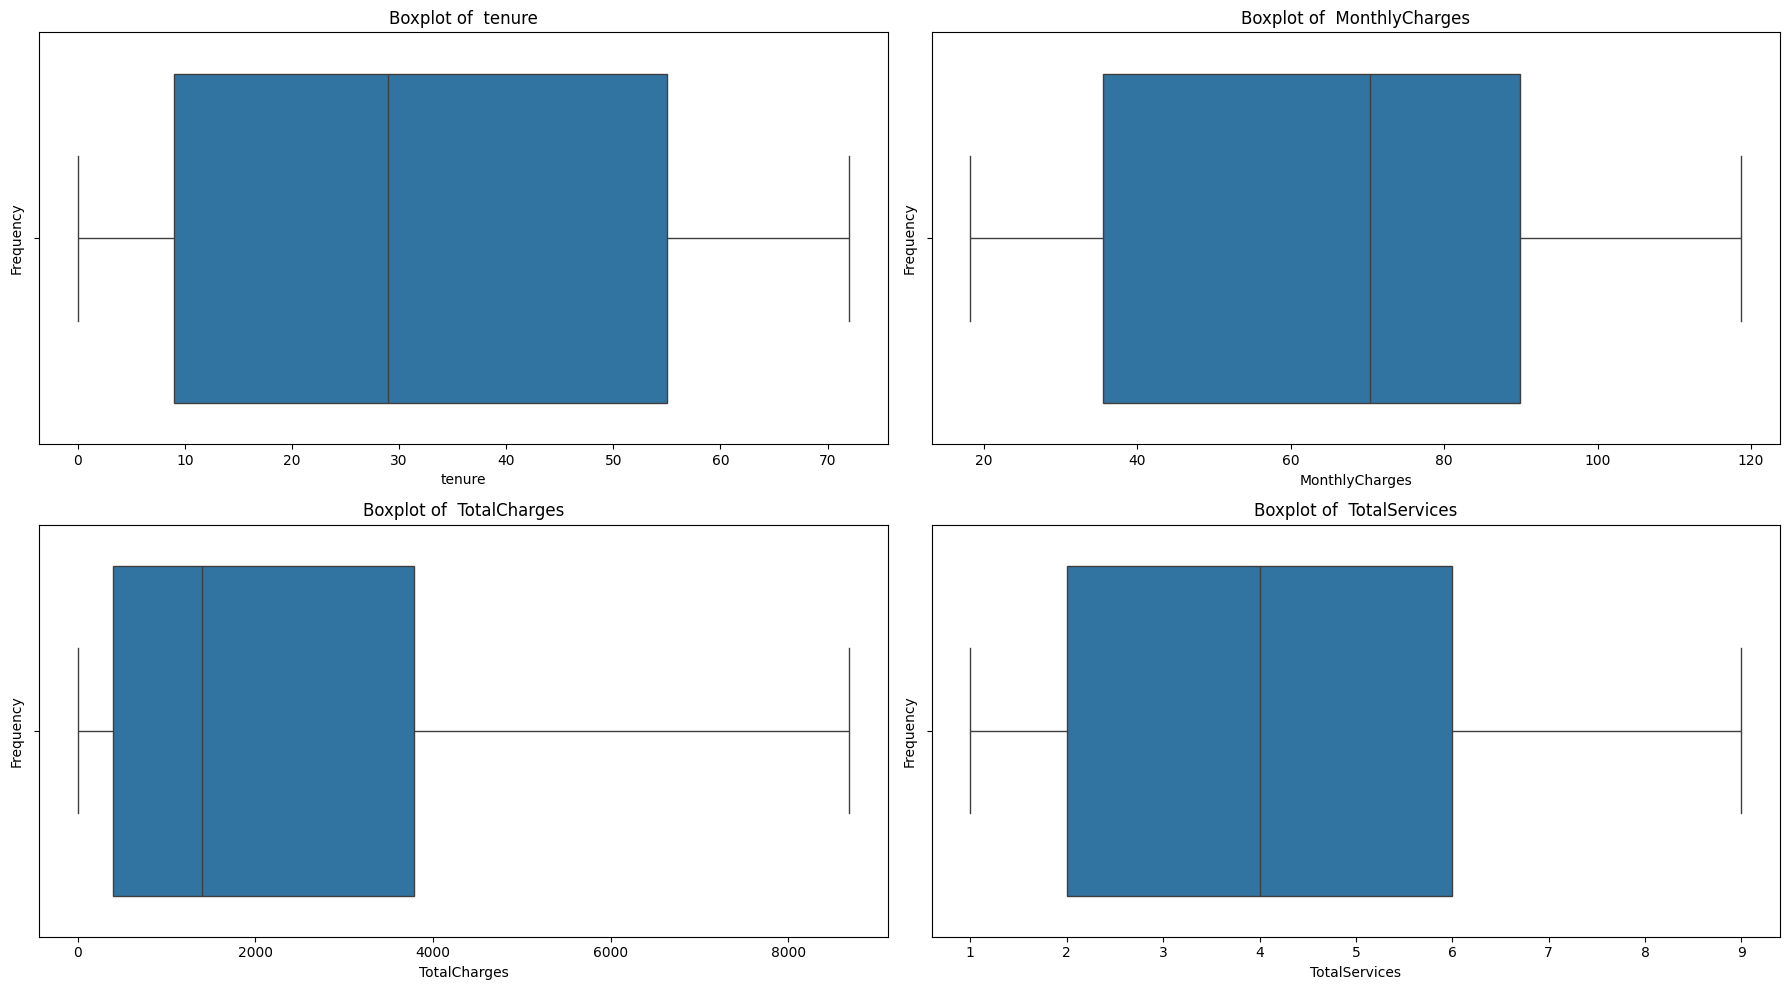

In [26]:
# Boxplots of numerical variables
plt.figure(figsize=(18,10)) # define figure size

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=col, data=eda_data[numerical_columns])
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Boxplot of  {col}')
plt.tight_layout()
plt.show()

### Summary of Univariate analysis (Categorical data)

EDA reviewed key insights into customer demographics, service preferences, account types, and churn rates. The gender distribution is balanced, with most customers being non-senior citizens without dependents or partners, suggesting a trend towards individual or smaller households. Most customers have phone service, but fewer opt for multiple lines. Fibre-optic internet is the preferred service. Low adoption of additional services, such as online security and tech support, indicates potential areas for growth. Month-to-month contracts are the most popular, and paperless billing is preferred. The churn rate is low, with most customers retaining their services.

Customer tenure ranges from 1 to 72 months, with a median of 30 months and a right-skewed distribution. Monthly charges range from 18 to 119, with a median of 70 and a slight left skew. Total charges range from 18 to 8684, with a median of 2000 and a right-skewed distribution, indicating that a few customers have very high charges. Total services range from 1 to 9, with a median of 3 and discrete peaks. 

These insights reveal significant skewness in the numerical data, highlighting variability in customer tenure, charges, and service subscriptions.

#### Bivariate Analysis (Categorical Variables)

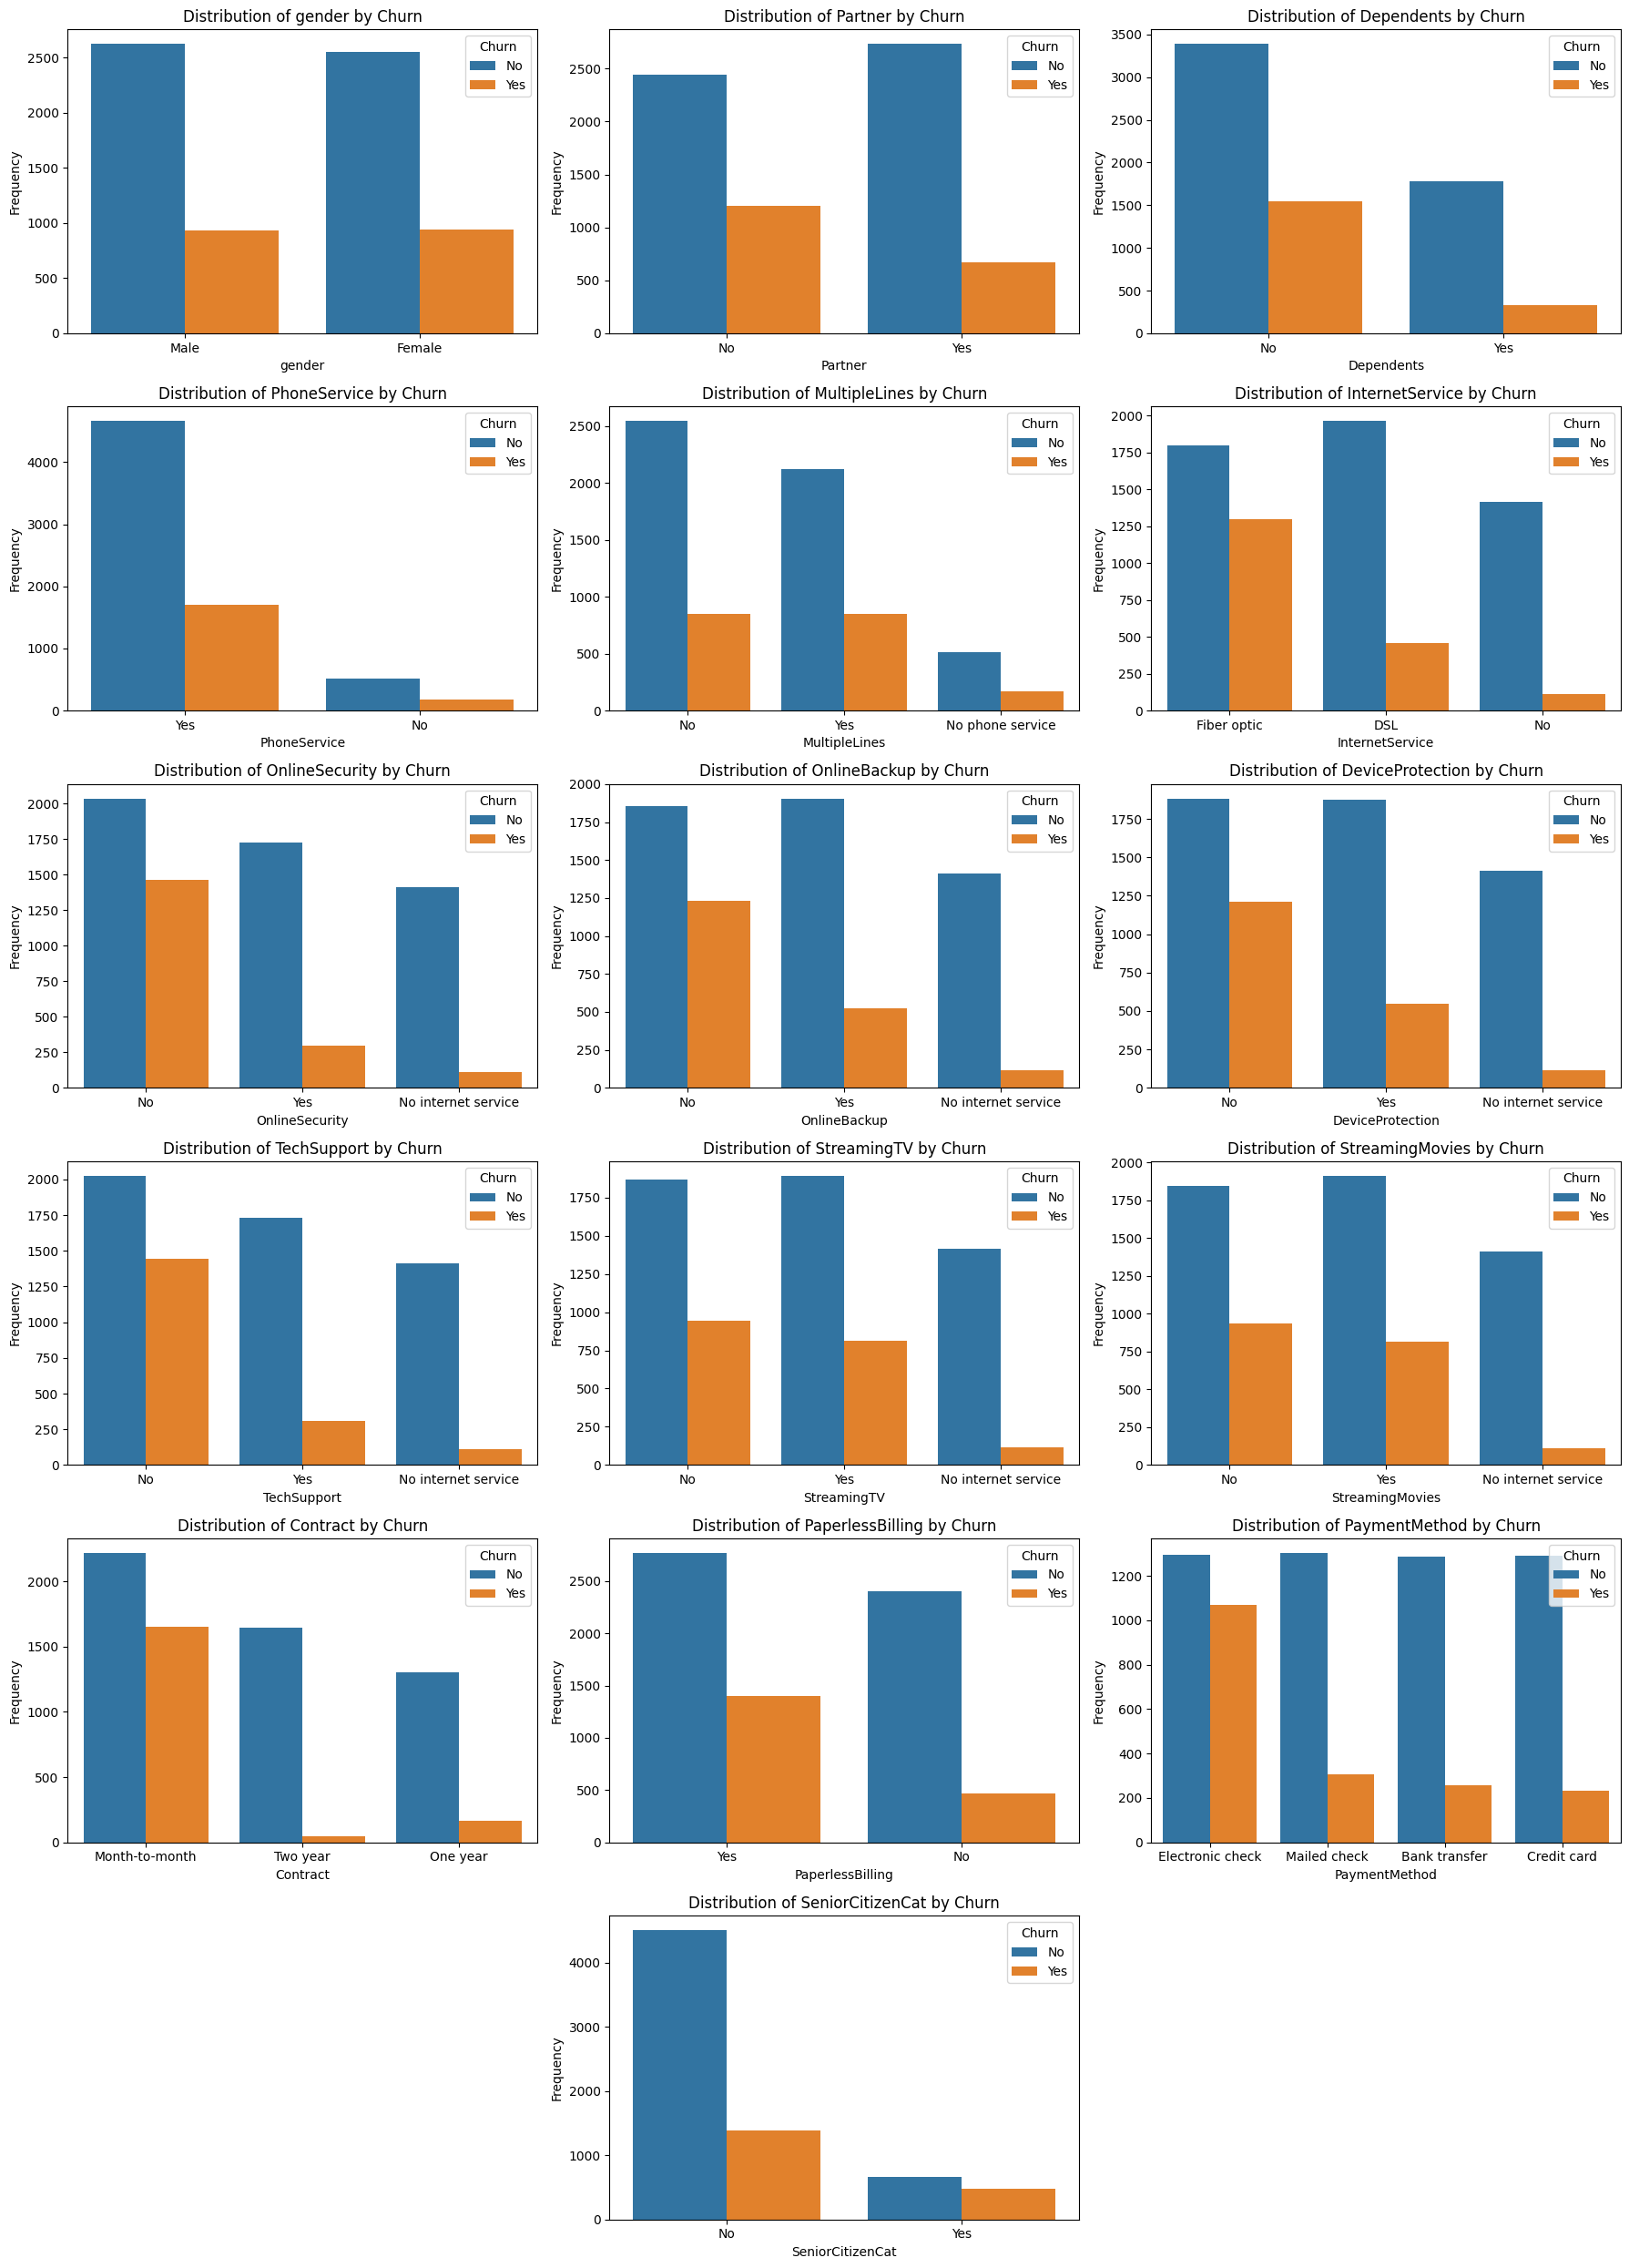

In [27]:
# Bivariate analysis for categorical variables with Churn label
plt.figure(figsize=(18,25)) # define figure size

for i, col in enumerate(eda_data[categorical_columns], 1):
    if col != 'Churn':
        plt.subplot(6, 3, i)
        sns.countplot(
            x=col, hue='Churn', 
            data=eda_data[categorical_columns], 
            order=eda_data[categorical_columns][col].value_counts().index
        )
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col} by Churn')
        
plt.tight_layout()
plt.show()

### Bivariate analysis (numerical data) with Churn label

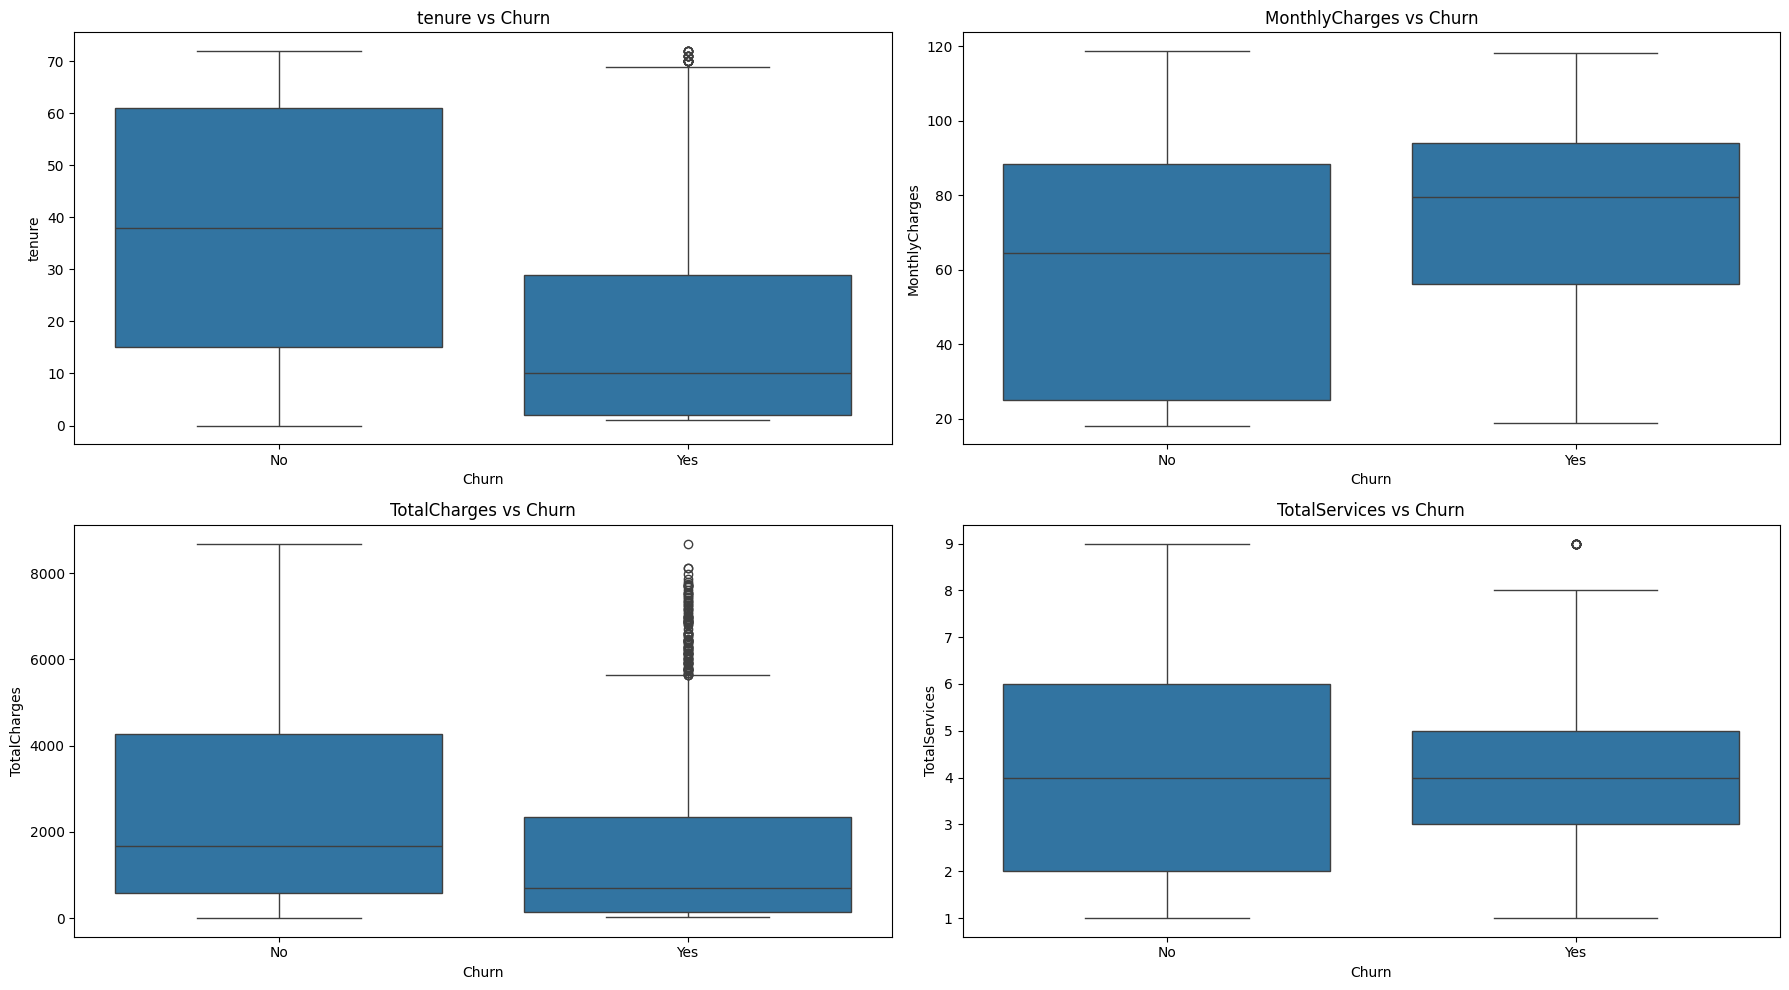

In [28]:
# boxplot of numerical variables by churn
plt.figure(figsize=(18,10)) # define figure size

# create a boxplot using a loop
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=eda_data['Churn'], y=column, data=eda_data[numerical_columns])
    plt.title(f'{column} vs Churn')
    plt.xlabel('Churn')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### Bivariate analysis (feature to feature)

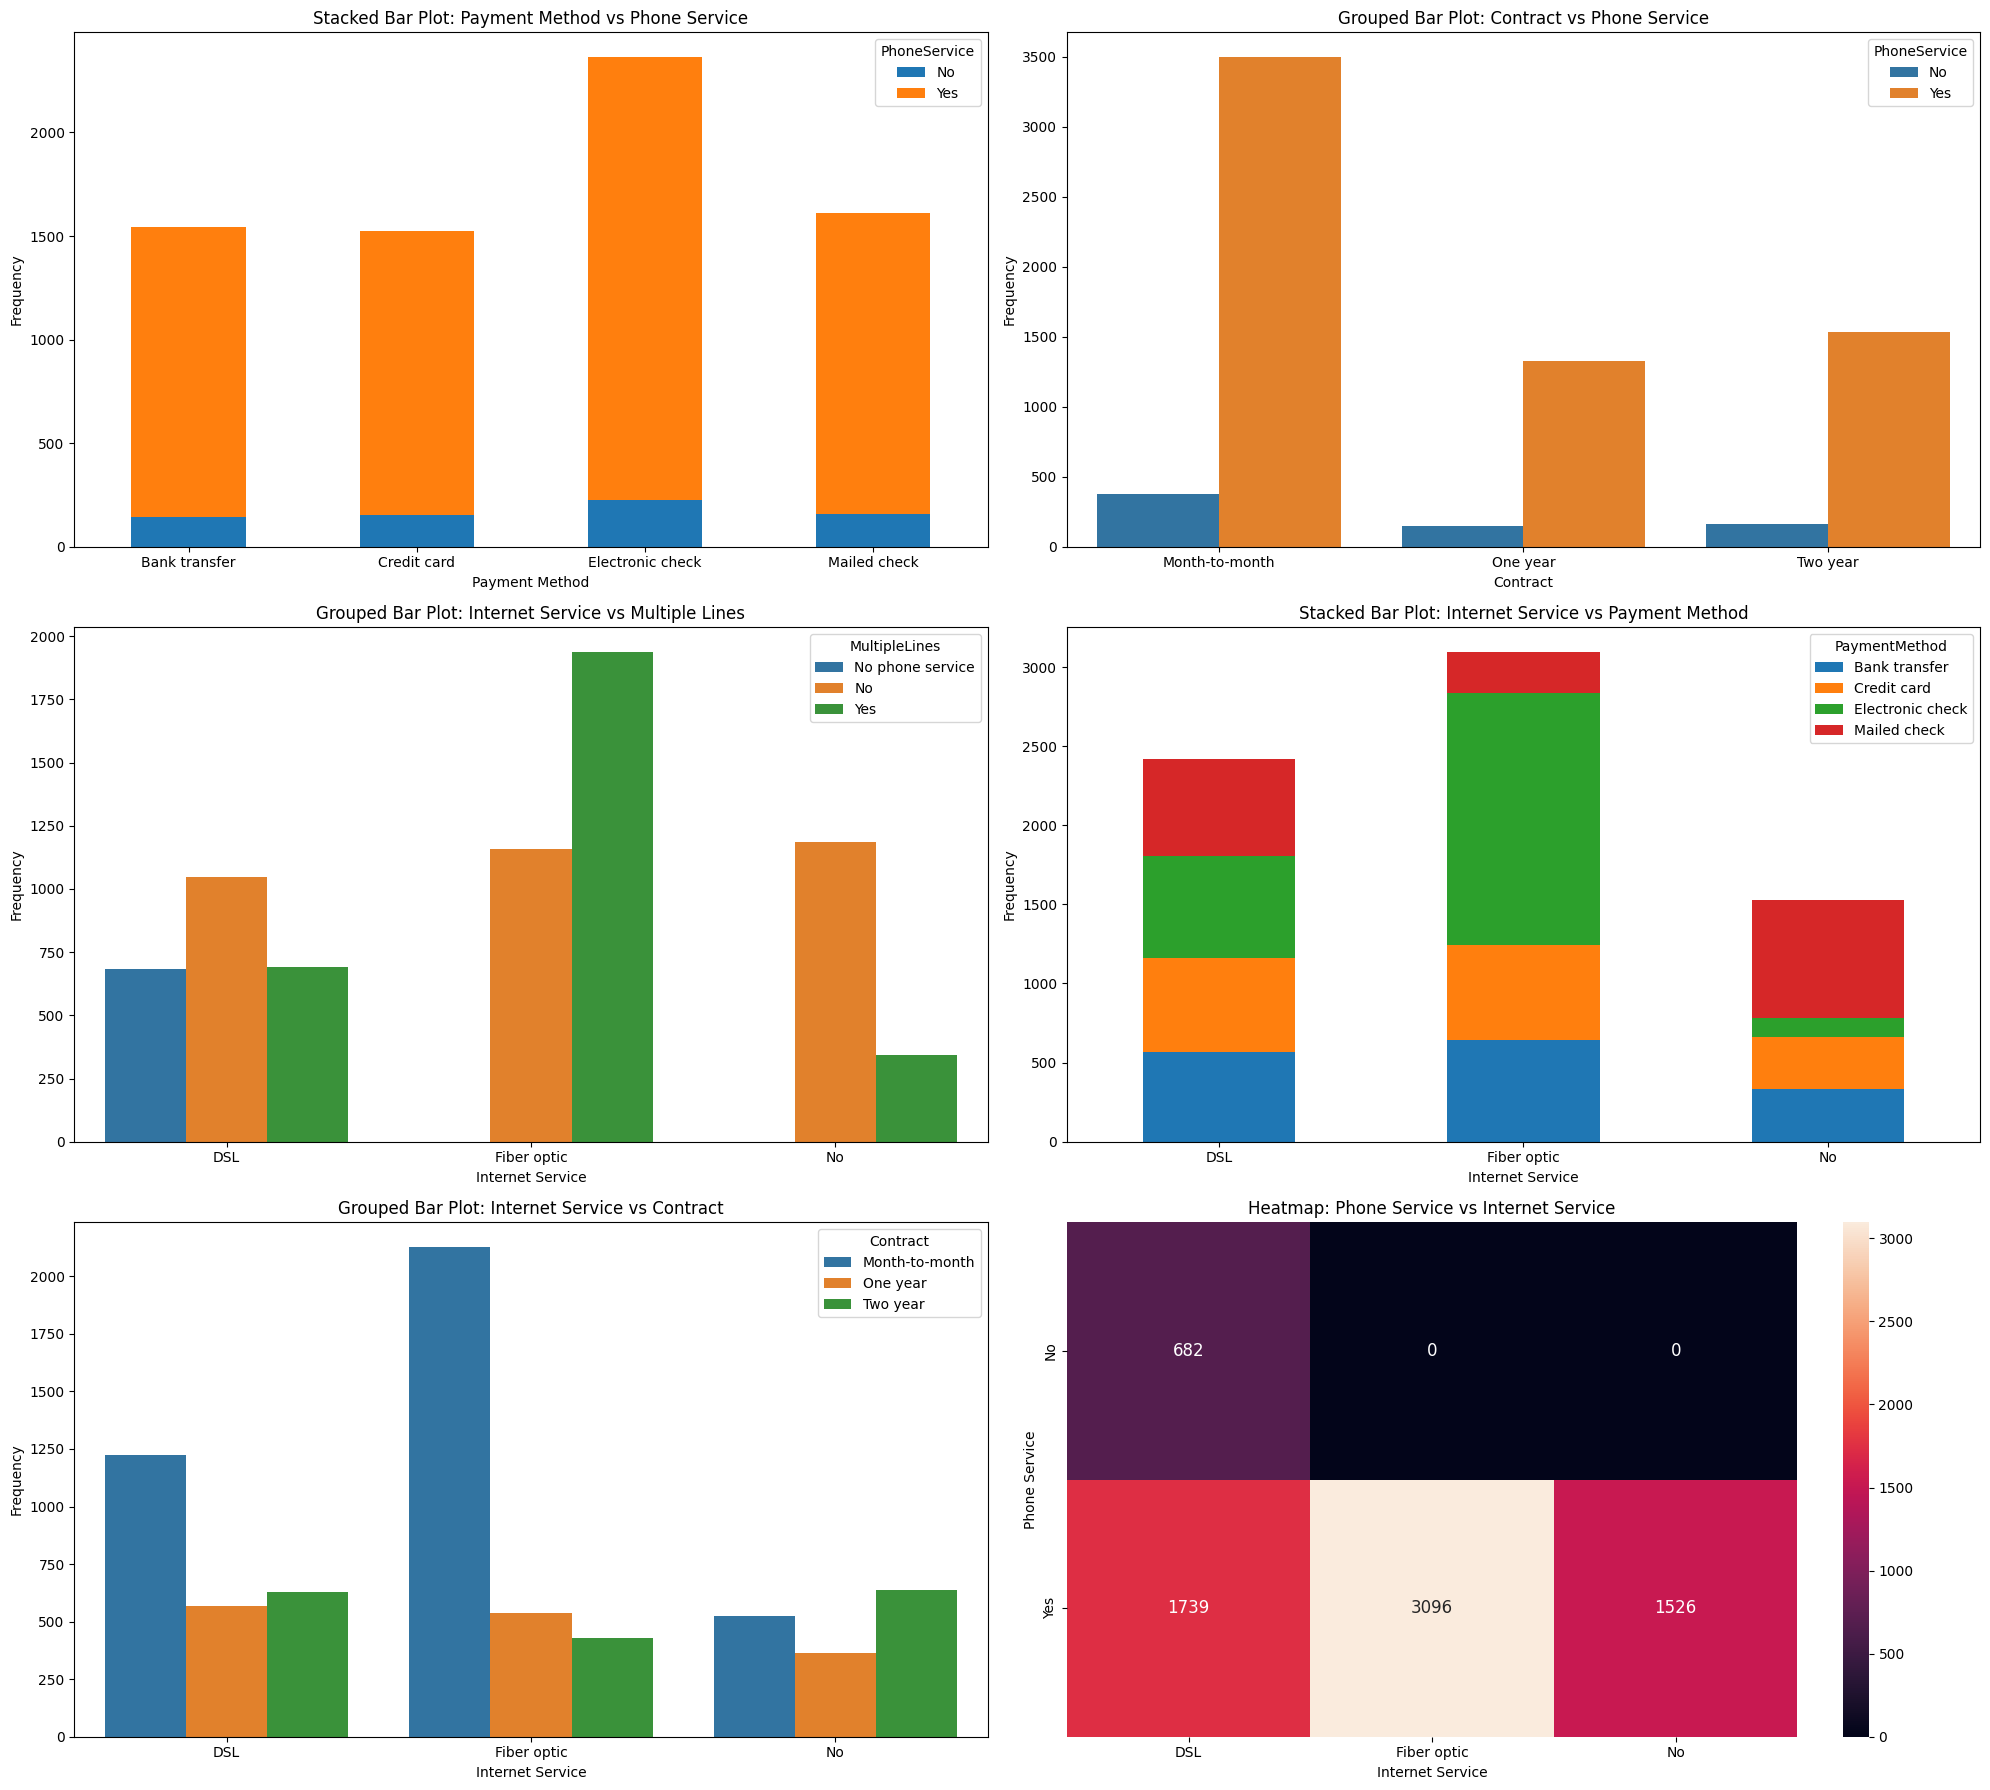

In [29]:
# Bivariate analysis
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Bivariate analysis - relationship between internet services and payment method
ct1 = pd.crosstab(eda_data['PaymentMethod'], eda_data['PhoneService'])
ct1.plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title('Stacked Bar Plot: Payment Method vs Phone Service')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlabel('Payment Method')
axes[0, 0].set_xticks(axes[0, 0].get_xticks())
axes[0, 0].set_xticklabels(ct1.index, rotation=0)

# Bivariate analysis - relationship between internet services and multiple lines
sns.countplot(x='Contract', hue='PhoneService', data=eda_data, ax=axes[0, 1])
axes[0, 1].set_title('Grouped Bar Plot: Contract vs Phone Service')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlabel('Contract')

# Bivariate analysis - relationship between internet services and multiple lines
sns.countplot(x='InternetService', hue='MultipleLines', data=eda_data, ax=axes[1, 0])
axes[1, 0].set_title('Grouped Bar Plot: Internet Service vs Multiple Lines')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlabel('Internet Service')

# Bivariate analysis - relationship between internet services and payment method
ct2 = pd.crosstab(eda_data['InternetService'], eda_data['PaymentMethod'])
ct2.plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Stacked Bar Plot: Internet Service vs Payment Method')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlabel('Internet Service')
axes[1, 1].set_xticks(axes[1, 1].get_xticks())
axes[1, 1].set_xticklabels(ct2.index, rotation=0)

# Bivariate analysis - relationship between internet services and contract
sns.countplot(x='InternetService', hue='Contract', data=eda_data, ax=axes[2, 0])
axes[2, 0].set_title('Grouped Bar Plot: Internet Service vs Contract')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_xlabel('Internet Service')

# Bivariate analysis - relationship between internet services and phone services
ct3 = pd.crosstab(eda_data['PhoneService'], eda_data['InternetService'])
sns.heatmap(ct3, annot=True, fmt='d', annot_kws={"size": 12}, ax=axes[2, 1])
axes[2, 1].set_title('Heatmap: Phone Service vs Internet Service')
axes[2, 1].set_ylabel('Phone Service')
axes[2, 1].set_xlabel('Internet Service')

plt.tight_layout()
plt.show()

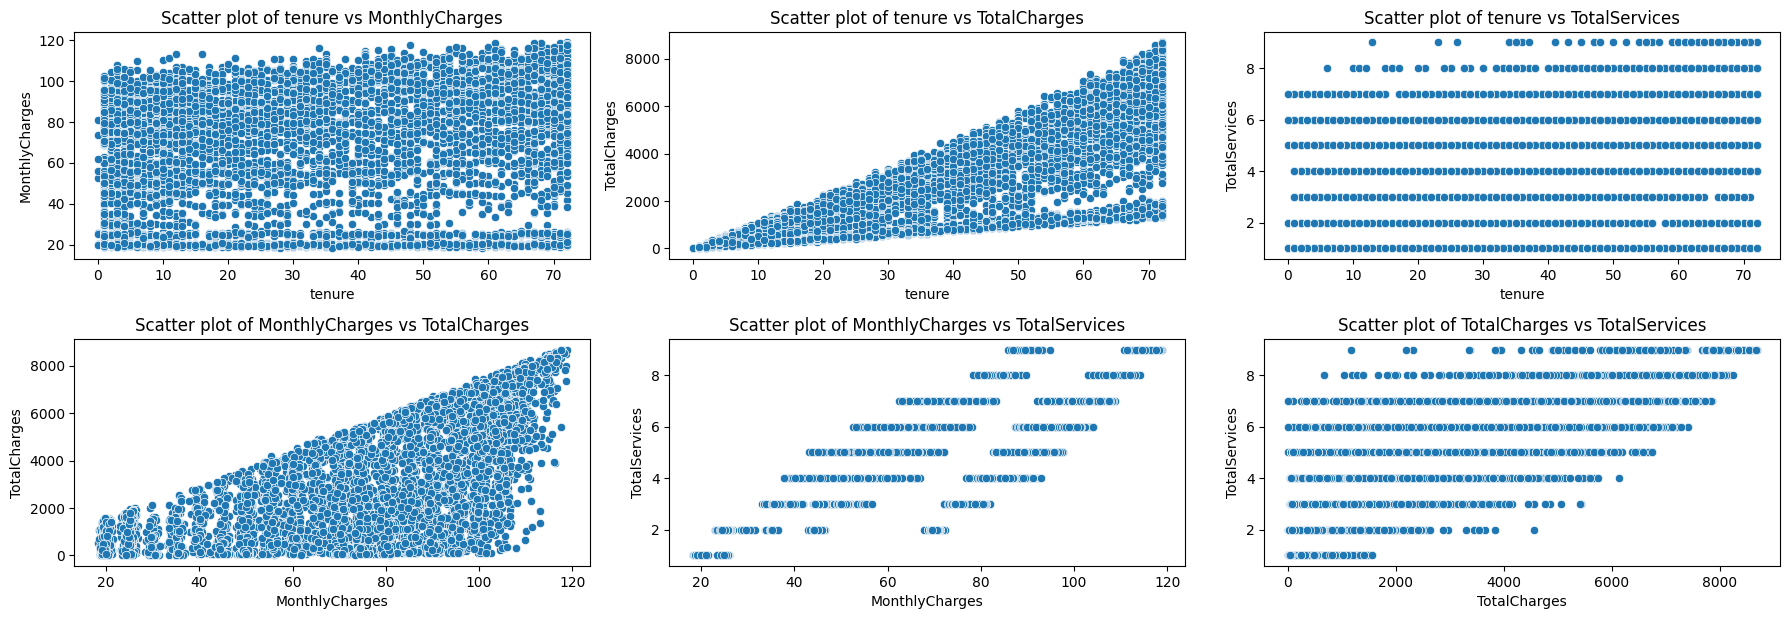

In [31]:
# Bivariate analysis for numerical variables
# Define figure size
plt.figure(figsize=(18, 12)) 

# Get the column names
col_names = eda_data[numerical_columns].columns

# Initialize a plot counter
plot_number = 1

# Loop through each pair of columns in the dataframe
for i in range(len(col_names)):
    for j in range(i + 1, len(col_names)):
        # Create a subplot for each pair of columns
        plt.subplot(len(col_names), len(col_names) - 1, plot_number)
        
        # Create a scatter plot for the current pair of columns
        sns.scatterplot(x=eda_data[col_names[i]], y=eda_data[col_names[j]])
        
        # Set the x-axis label to the name of the current x-column
        plt.xlabel(col_names[i])
        
        # Set the y-axis label to the name of the current y-column
        plt.ylabel(col_names[j])
        
        # Set the title of the subplot to 'Scatter plot of {x-column} vs {y-column}'
        plt.title(f'Scatter plot of {col_names[i]} vs {col_names[j]}')
        
        # Increment the plot counter
        plot_number += 1

plt.tight_layout()
plt.show()

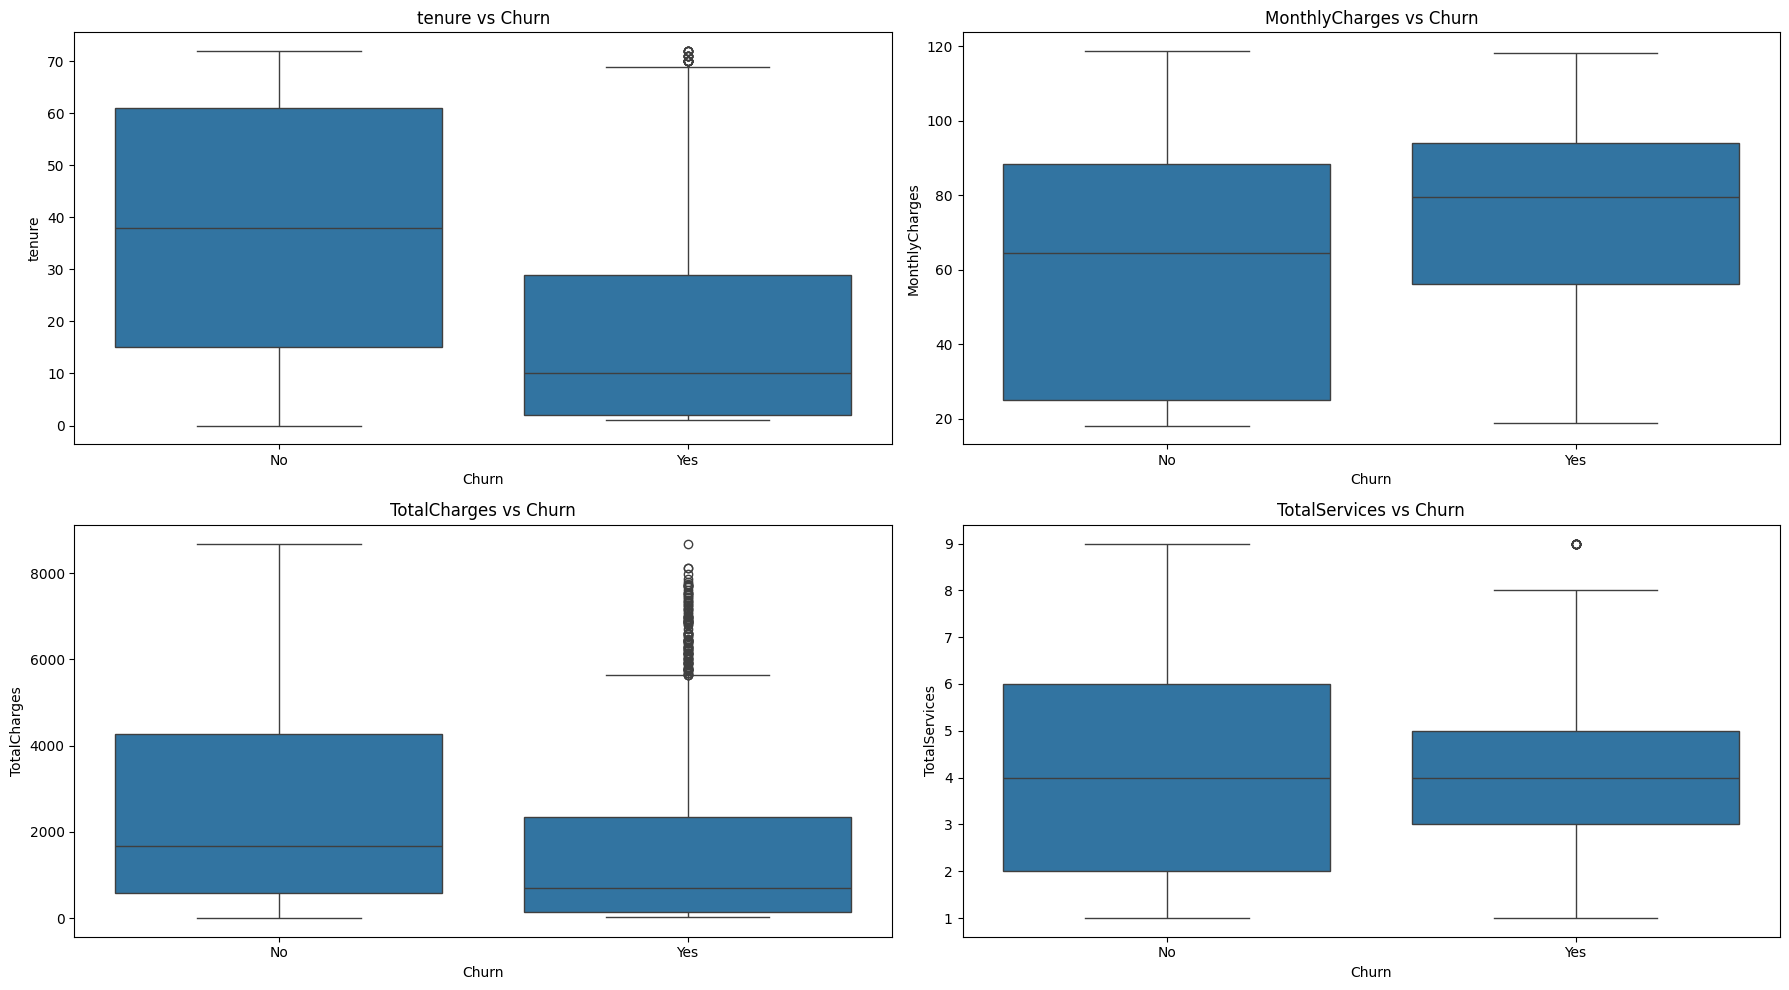

In [32]:
# boxplot of numerical variables by churn
plt.figure(figsize=(18,10)) # define figure size

# create a boxplot using a loop
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=eda_data['Churn'], y=column, data=eda_data[numerical_columns])
    plt.title(f'{column} vs Churn')
    plt.xlabel('Churn')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### Summary of Bivariate analysis

EDA analysed various categorical and numerical variables related to the customer churn target, and the key findings include:

- **Demographics:** Senior citizens and customers without partners or dependents have higher churn rates, while gender shows no significant impact.
- **Services:**
  - **Phone Service:** No significant churn difference based on phone service alone.
  - **Internet Service:** Fiber optic customers churn more than DSL or non-internet users.
  - **Add-ons:** Absence of services like online security and streaming increases churn.
  - **Contract:** Monthly contracts lead to higher churn compared to longer contracts.
  - **Billing:** Paperless billing and electronic check payments correlate with higher churn.
- **Tenure vs. Churn**: Customers with shorter tenures are more likely to churn than those with longer tenures.
- **Monthly Charges vs. Churn**: Higher monthly charges are associated with higher churn rates, suggesting cost is a driving factor for churn.
- **Total Charges vs. Churn**: There is no significant difference, but higher total charges may relate to accumulated costs over time, influencing churn.
- **Total Services vs. Churn**: Fewer total services correlate with higher churn, although this factor is less significant.

An analysis of the relationships between numerical variables revealed the following insights:

- **Tenure vs. MonthlyCharges:** No clear linear relationship exists with a dispersed pattern.
- **Tenure vs. TotalCharges:** A positive correlation is observed; although not perfectly linear, tenure increases as total charges increase.
- **Tenure vs. TotalServices:** There is a slight upward trend that suggests longer tenures may involve more services, but the relationship is weak.
- **MonthlyCharges vs. TotalCharges:** There is a strong positive linear correlation; higher monthly charges lead to higher total charges.
- **MonthlyCharges vs. TotalServices:** No strong relationship with a dispersed pattern is observed.
- **TotalCharges vs. TotalServices:** Some clustering is noted, but no strong linear relationship.


Overall, factors such as age, relationship status, internet service type, monthly charges and contract length significantly impact customer churn, with longer tenure reducing churn rates.

### Multivariate Analysis

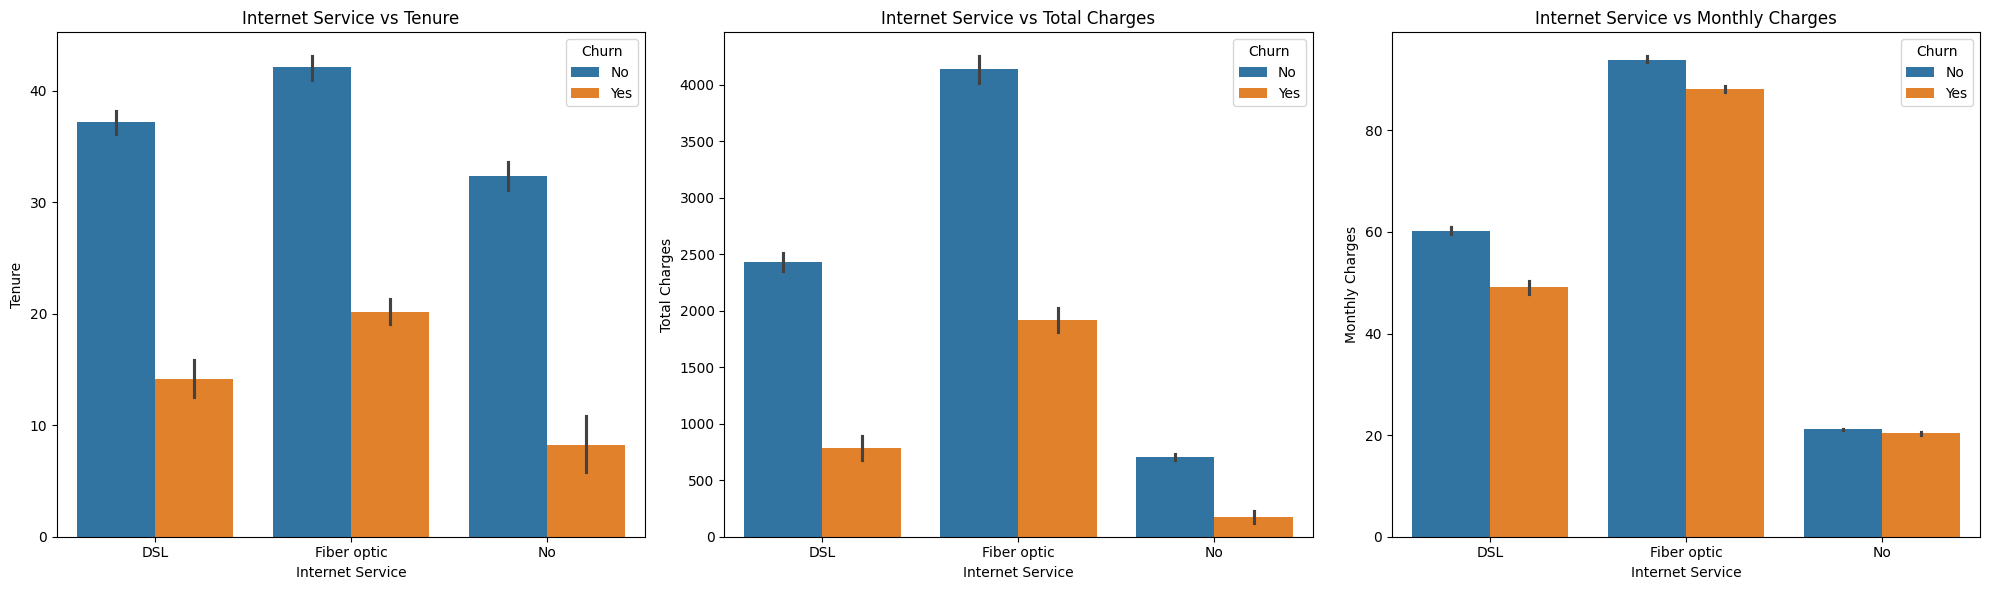

In [33]:
# Multivariate analysis in Internet Service vs Tenure on Churn label
# Define the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: InternetService vs Tenure
sns.barplot(x='InternetService', y='tenure', hue='Churn', data=eda_data, ax=axes[0])
axes[0].set_xlabel('Internet Service')
axes[0].set_ylabel('Tenure')
axes[0].set_title('Internet Service vs Tenure')

# Plot 2: InternetService vs TotalCharges
sns.barplot(x='InternetService', y='TotalCharges', hue='Churn', data=eda_data, ax=axes[1])
axes[1].set_xlabel('Internet Service')
axes[1].set_ylabel('Total Charges')
axes[1].set_title('Internet Service vs Total Charges')

# Plot 3: InternetService vs MonthlyCharges
sns.barplot(x='InternetService', y='MonthlyCharges', hue='Churn', data=eda_data, ax=axes[2])
axes[2].set_xlabel('Internet Service')
axes[2].set_ylabel('Monthly Charges')
axes[2].set_title('Internet Service vs Monthly Charges')

plt.tight_layout()
plt.show()

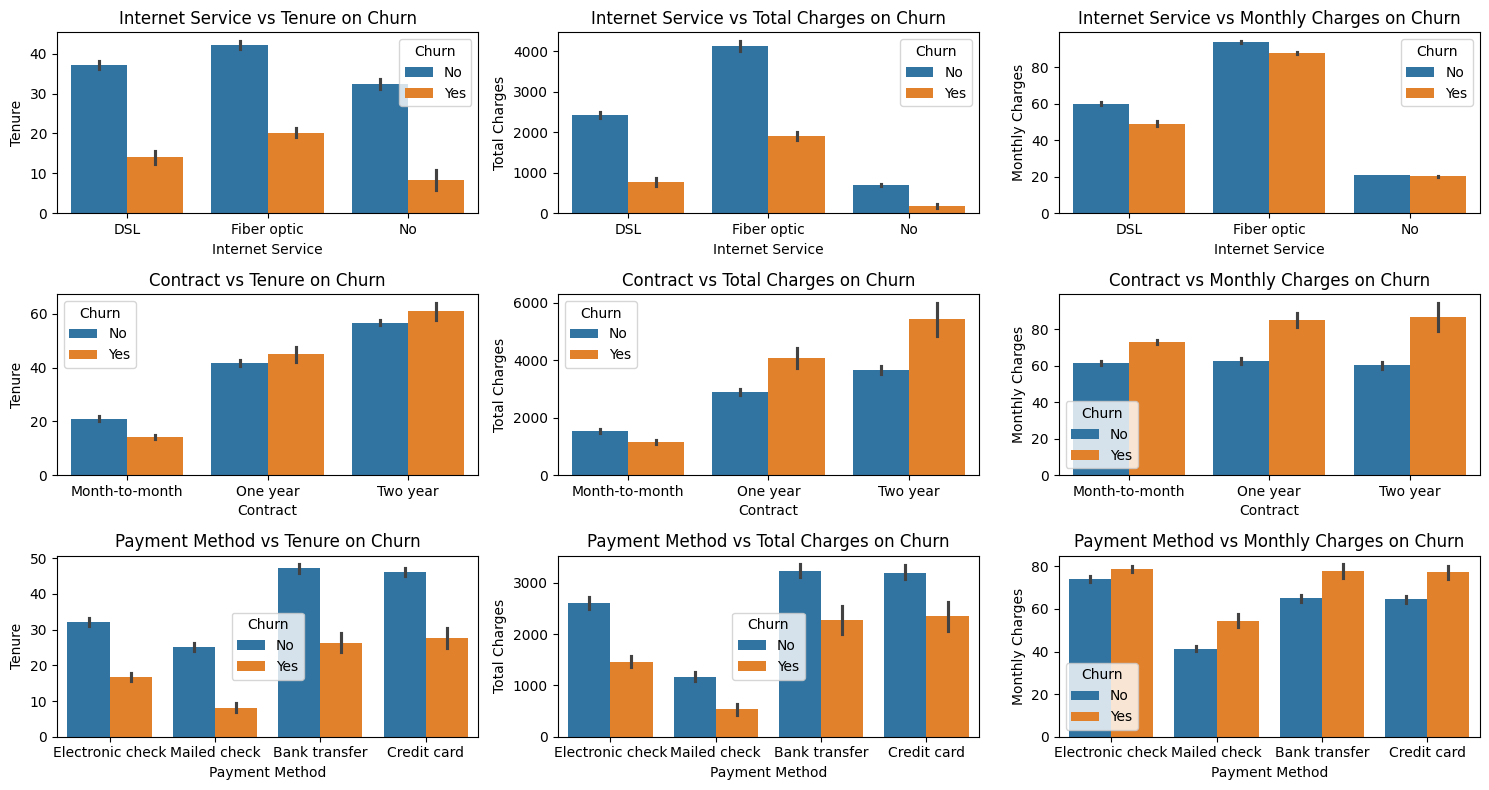

In [34]:
fig, axes = plt.subplots(3, 3, figsize=(15, 8))

# Internet Service vs Tenure
sns.barplot(x='InternetService', y='tenure', hue='Churn', data=eda_data, ax=axes[0,0])
axes[0,0].set_xlabel('Internet Service')
axes[0,0].set_ylabel('Tenure')
axes[0,0].set_title('Internet Service vs Tenure on Churn')
# Internet Service vs Total Charges
sns.barplot(x='InternetService', y='TotalCharges', hue='Churn', data=eda_data, ax=axes[0,1])
axes[0,1].set_xlabel('Internet Service')
axes[0,1].set_ylabel('Total Charges')
axes[0,1].set_title('Internet Service vs Total Charges on Churn')
# Internet Service vs Monthly Charges
sns.barplot(x='InternetService', y='MonthlyCharges', hue='Churn', data=eda_data, ax=axes[0,2])
axes[0,2].set_xlabel('Internet Service')
axes[0,2].set_ylabel('Monthly Charges')
axes[0,2].set_title('Internet Service vs Monthly Charges on Churn')
# Contract vs Tenure
sns.barplot(x='Contract', y='tenure', hue='Churn', data=eda_data, ax=axes[1,0])
axes[1,0].set_xlabel('Contract')
axes[1,0].set_ylabel('Tenure')
axes[1,0].set_title('Contract vs Tenure on Churn')
# Contract vs Total Charges
sns.barplot(x='Contract', y='TotalCharges', hue='Churn', data=eda_data, ax=axes[1,1])
axes[1,1].set_xlabel('Contract')
axes[1,1].set_ylabel('Total Charges')
axes[1,1].set_title('Contract vs Total Charges on Churn')
# Contract vs MonthlyC harges
sns.barplot(x='Contract', y='MonthlyCharges', hue='Churn', data=eda_data, ax=axes[1,2])
axes[1,2].set_xlabel('Contract')
axes[1,2].set_ylabel('Monthly Charges')
axes[1,2].set_title('Contract vs Monthly Charges on Churn')
# Payment Method vs Tenure on Churn
sns.barplot(x='PaymentMethod', y='tenure', hue='Churn', data=eda_data, ax=axes[2,0])
axes[2,0].set_xlabel('Payment Method')
axes[2,0].set_ylabel('Tenure')
axes[2,0].set_title('Payment Method vs Tenure on Churn')
# Payment Method vs Total Charges on Churn
sns.barplot(x='PaymentMethod', y='TotalCharges', hue='Churn', data=eda_data, ax=axes[2,1])
axes[2,1].set_xlabel('Payment Method')
axes[2,1].set_ylabel('Total Charges')
axes[2,1].set_title('Payment Method vs Total Charges on Churn')
# Payment Method vs Monthly Charges on Churn
sns.barplot(x='PaymentMethod', y='MonthlyCharges', hue='Churn', data=eda_data, ax=axes[2,2])
axes[2,2].set_xlabel('Payment Method')
axes[2,2].set_ylabel('Monthly Charges')
axes[2,2].set_title('Payment Method vs Monthly Charges on Churn')
plt.tight_layout()
plt.show()

#### Multivariate analysis for numerical variables with Churn label

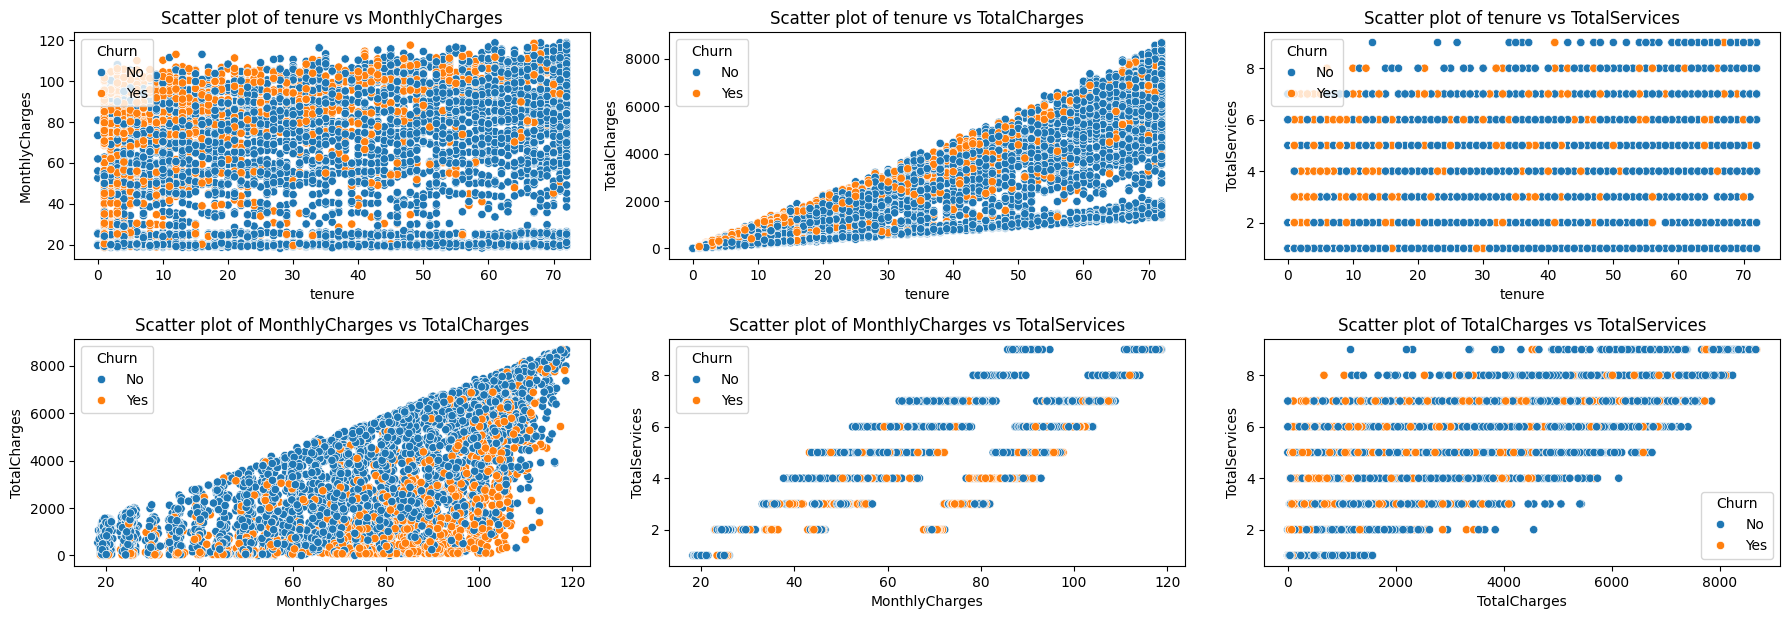

In [35]:
# Define figure size
plt.figure(figsize=(18, 12)) 

# Get the column names
col_names = eda_data[numerical_columns].columns

# Initialise a plot counter
plot_number = 1

# Loop through each pair of columns in the dataframe
for i in range(len(col_names)):
    for j in range(i + 1, len(col_names)):
        # Create a subplot for each pair of columns
        plt.subplot(len(col_names), len(col_names) - 1, plot_number)
        
        # Create a scatter plot for the current pair of columns
        sns.scatterplot(x=eda_data[col_names[i]], y=eda_data[col_names[j]], hue=eda_data['Churn'])
        
        # Set the x-axis label to the name of the current x-column
        plt.xlabel(col_names[i])
        
        # Set the y-axis label to the name of the current y-column
        plt.ylabel(col_names[j])
        
        # Set the title of the subplot to 'Scatter plot of {x-column} vs {y-column}'
        plt.title(f'Scatter plot of {col_names[i]} vs {col_names[j]}')
        
        # Increment the plot counter
        plot_number += 1

plt.tight_layout()
plt.show()

### Summary of Multivariate Analysis (numerical variable vs churn)
Multivariate analysis reveals that customer churn is higher among those with shorter tenures, higher monthly charges, and fewer services. Customers with lower total charges and fewer services also exhibit higher churn rates. A linear relationship exists between monthly and total charges, with higher churn rates for those with high monthly but low total charges. Customers with higher monthly charges and fewer services are most prone to churn

#### Relationship between Tenure, Contract Type, and Churn

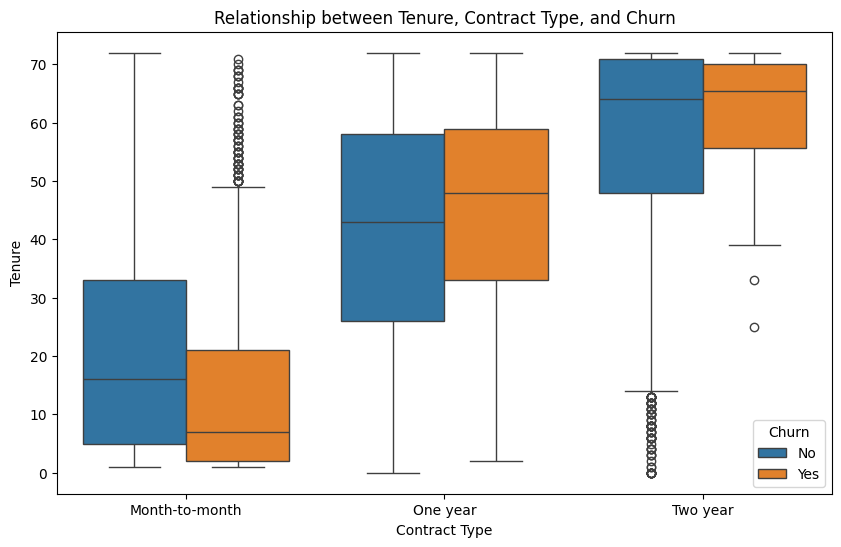

In [40]:
# Create a plot showing the relationship between Tenure, Contract Type, and Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Contract', y='tenure', hue='Churn', data=eda_data)
plt.title('Relationship between Tenure, Contract Type, and Churn')
plt.xlabel('Contract Type')
plt.ylabel('Tenure')
plt.legend(title='Churn')
plt.show()

#### Summary of the Relationship between Tenure, Contract Type, and Churn
Month-to-month contracts show high churn and shorter tenures. One-year contracts have more consistent tenures and lower churn. Two-year contracts demonstrate the longest tenures and lowest churn rates, indicating better retention. Short-term tenures are associated with higher churn, while longer tenures correlate with lower churn, particularly in longer contracts.

#### Comparing Internet Service and Payment Method on Churn

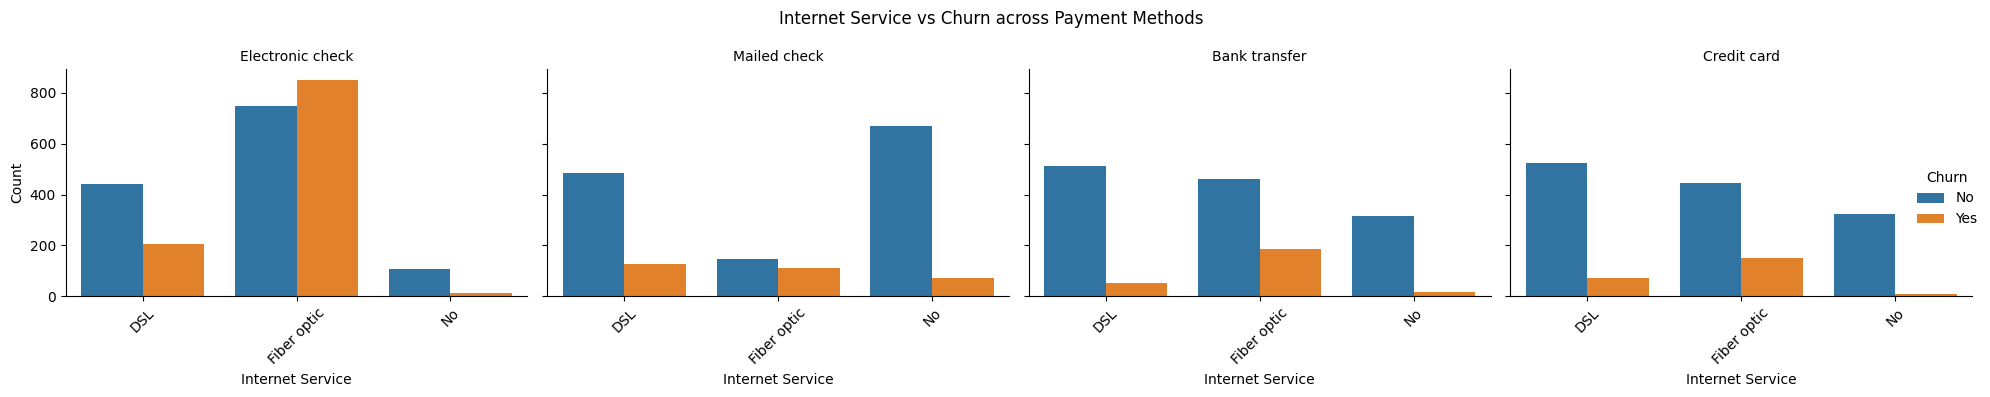

In [41]:
# Comparing Internet Service and Payment Method on Churn
g = sns.catplot(data=eda_data, x='InternetService', hue='Churn', col='PaymentMethod', kind='count', height=4, aspect=1.2)
g.set_titles("{col_name}")
g.set_axis_labels("Internet Service", "Count")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Internet Service vs Churn across Payment Methods')
plt.tight_layout()
plt.show()

#### Comparing Internet Service and Payment Method on Churn
Customers using Fiber optic internet service and paying via electronic check have the highest churn rate. DSL users also exhibit notable churn, particularly with electronic check payments, but less so than Fiber optic users. Those paying via mailed check, bank transfer, or credit card generally show lower churn rates. The interaction between internet service type and payment method significantly influences churn, with Fiber optic users using electronic checks being the most prone to churn.

#### Comparing InternetService and TotalCharges on Churn

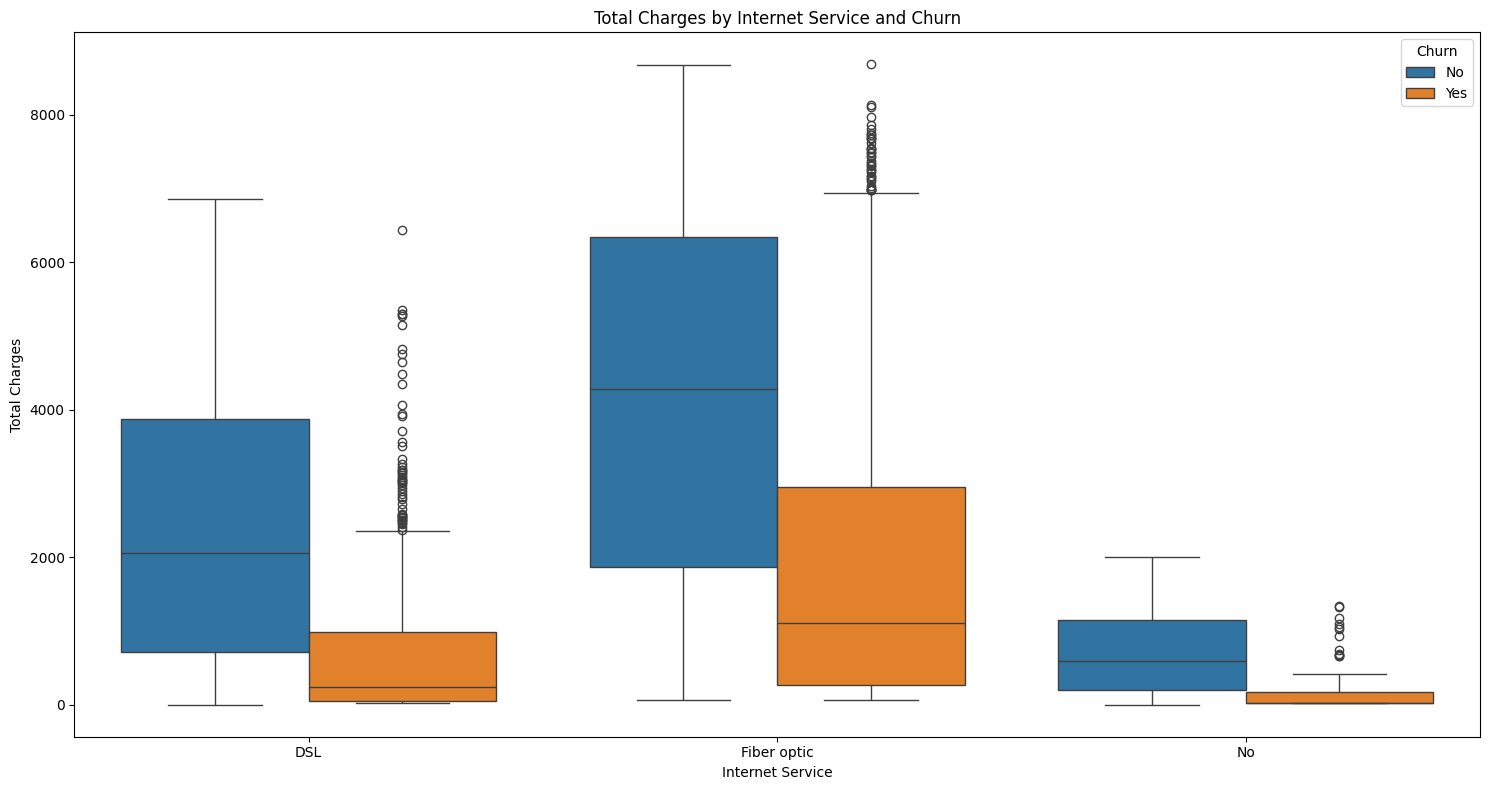

In [42]:
# Comparing InternetService and TotalCharges on Churn
plt.figure(figsize=(15, 8))

sns.boxplot(x='InternetService', y='TotalCharges', hue='Churn', data=eda_data)
plt.title('Total Charges by Internet Service and Churn')
plt.xlabel('Internet Service')
plt.ylabel('Total Charges')
plt.legend(title='Churn')

plt.tight_layout()
plt.show()

#### Comparing Internet Service and Total Charges on Churn
Customers with DSL and lower total charges tend to churn, while fiber optic customers have higher total charges overall. Customers without internet service have the lowest, most uniform charges, with fewer instances of churn. Notably, the difference in total charges between churned and non-churned customers is more significant for fiber optic service than DSL.

#### Relationships between multiple variables (Contract, PaymentMethod, PaperlessBilling and Churn)

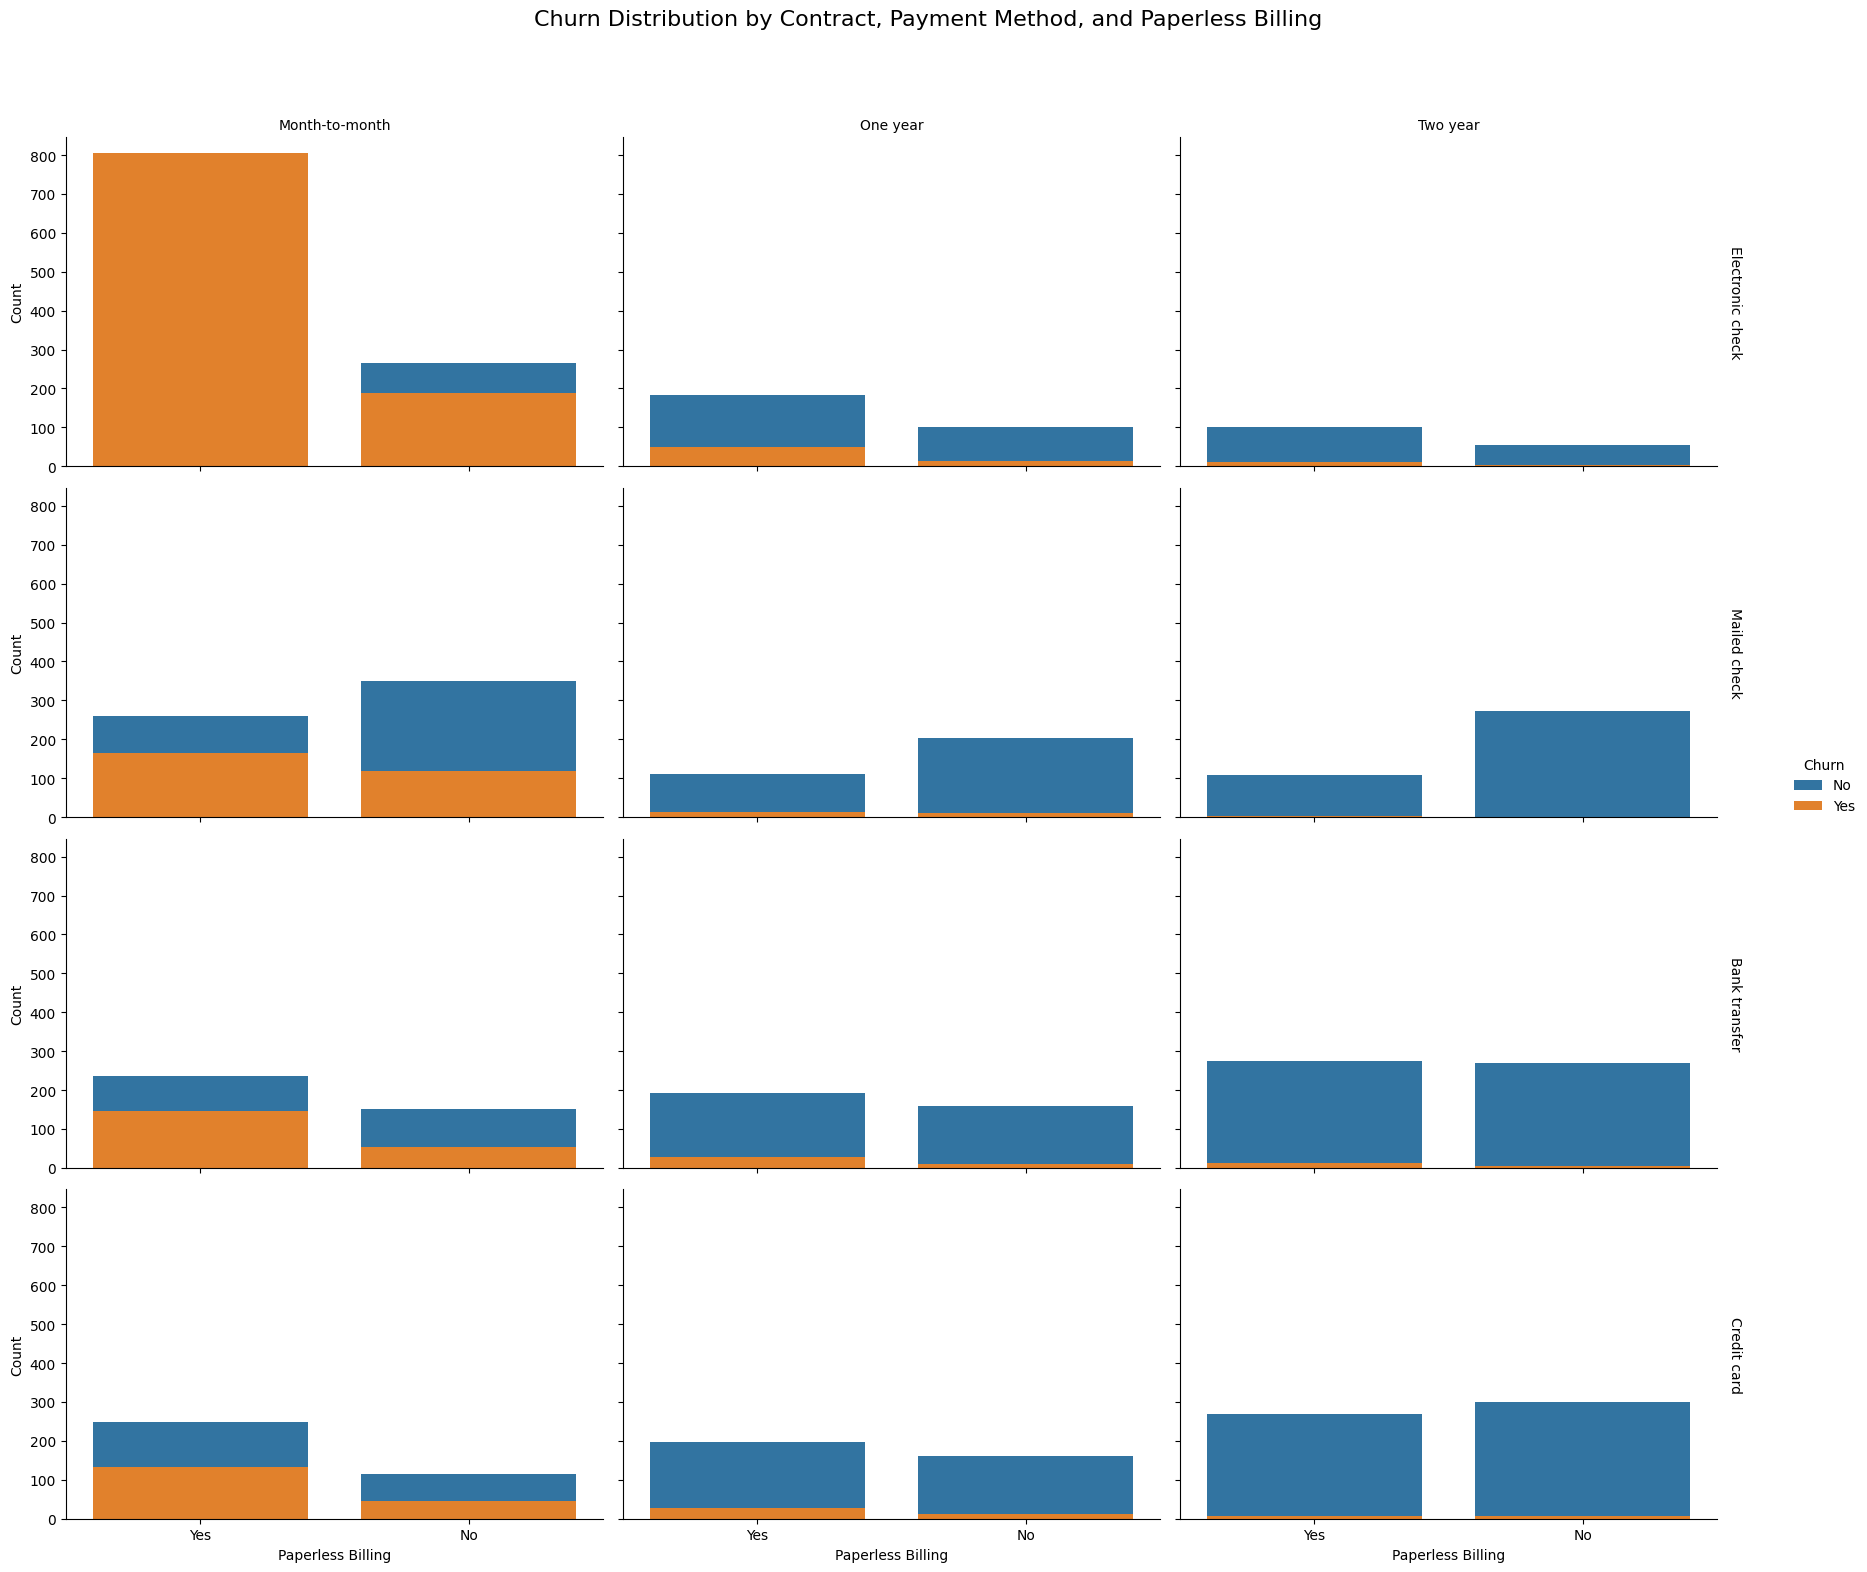

In [43]:
# Analysing relationships between multiple variables (Contract, PaymentMethod, PaperlessBilling and Churn)
g = sns.FacetGrid(eda_data, col="Contract", row="PaymentMethod", hue="Churn", margin_titles=True, height=4, aspect=1.5)
g.map_dataframe(sns.countplot, x="PaperlessBilling")
g.add_legend()
g.set_axis_labels("Paperless Billing", "Count")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Churn Distribution by Contract, Payment Method, and Paperless Billing', fontsize=16)
plt.show()

#### Churn Distribution by Contract, Payment Method, and Paperless Billing

Customers with monthly contracts and using electronic checks and paperless billing exhibit the highest churn rates. Electronic check users generally show higher churn, while automated payments (bank transfer and credit card) correlate with lower churn. These findings highlight the significant impact of contract type, payment method, and billing preferences on customer churn.

### Relationship between senior citizenship, partner status, and dependents on churn

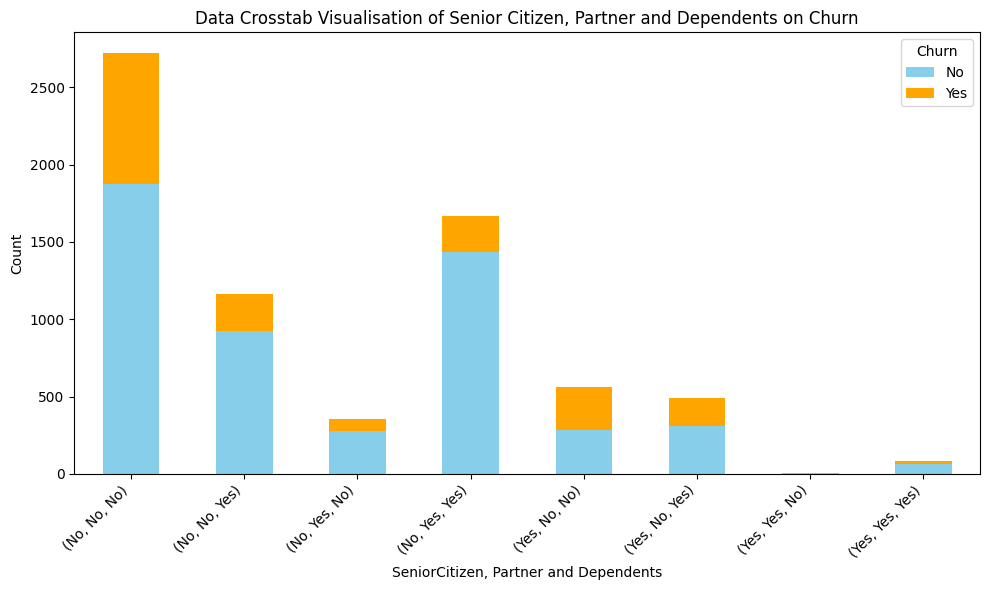

In [44]:
data_crosstab = pd.crosstab(index=[eda_data['SeniorCitizenCat'], 
							eda_data['Dependents'], eda_data['Partner']],
                            columns= eda_data['Churn']) 
# Plotting the crosstab
ax = data_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])

plt.title('Data Crosstab Visualisation of Senior Citizen, Partner and Dependents on Churn')
plt.xlabel('SeniorCitizen, Partner and Dependents')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Relationship between senior citizenship, partner status, and dependents on churn
A crosstab analysis reveals that senior and non-senior citizens show distinct churn patterns based on partner status and dependents. Non-senior citizens without dependents or a partner exhibit high churn rates, whereas those with both show the lowest churn rates. Dependents alone also reduce churn but less effectively. Among senior citizens, those without dependents and a partner have high churn rates, while those with both show significantly lower rates. Generally, senior citizens are more likely to churn, but having dependents and a partner considerably lowers their churn rate, both independently and collectively.

In [45]:
num_churn_encode = pd.concat(
    [eda_data[numerical_columns], cs_data['y']],
    axis=1
)

num_churn_encode.head()

tenure  MonthlyCharges  TotalCharges  TotalServices  y
0       1           29.85         29.85              2  0
1      34           56.95       1889.50              4  0
2       2           53.85        108.15              4  1
3      45           42.30       1840.75              4  0
4       2           70.70        151.65              2  1

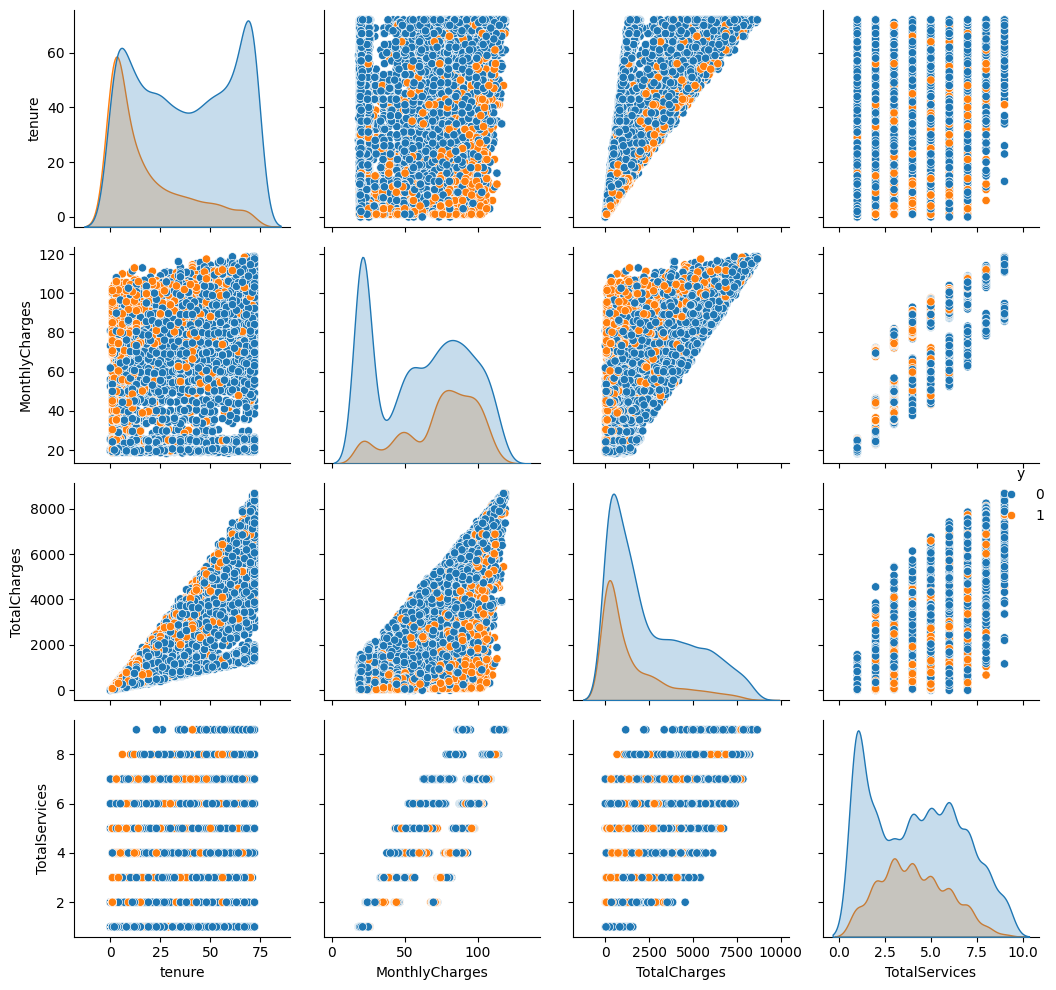

In [46]:
# pairplot with numerical columns and churn encoded label as hue
pairplot = sns.pairplot(num_churn_encode, hue='y', size=2.5)

plt.tight_layout()
plt.show()

The pairplot visualisation reveals that customers with shorter tenures have varied monthly charges, while those with longer tenures tend to have lower charges. There is a linear relationship between tenure and total charges. Higher monthly charges correlate with higher total charges. The distribution of customers across various total services does not clearly indicate a correlation with churn. Key observations show that customers with higher monthly charges and shorter tenures are more likely to churn.

### EDA Summary

EDA was conducted to understand churn distribution, compare churn rates across categorical features and examine numerical distributions (tenure, MonthlyCharges, TotalCharges).
Key observations include
- Short-tenure customers churn more frequently.
- Month-to-month contracts are associated with higher churn.
- Fiber optic customers show elevated churn risk.

These insights inform later feature engineering but do not directly influence feature removal.

### Correlation of Encoded Data

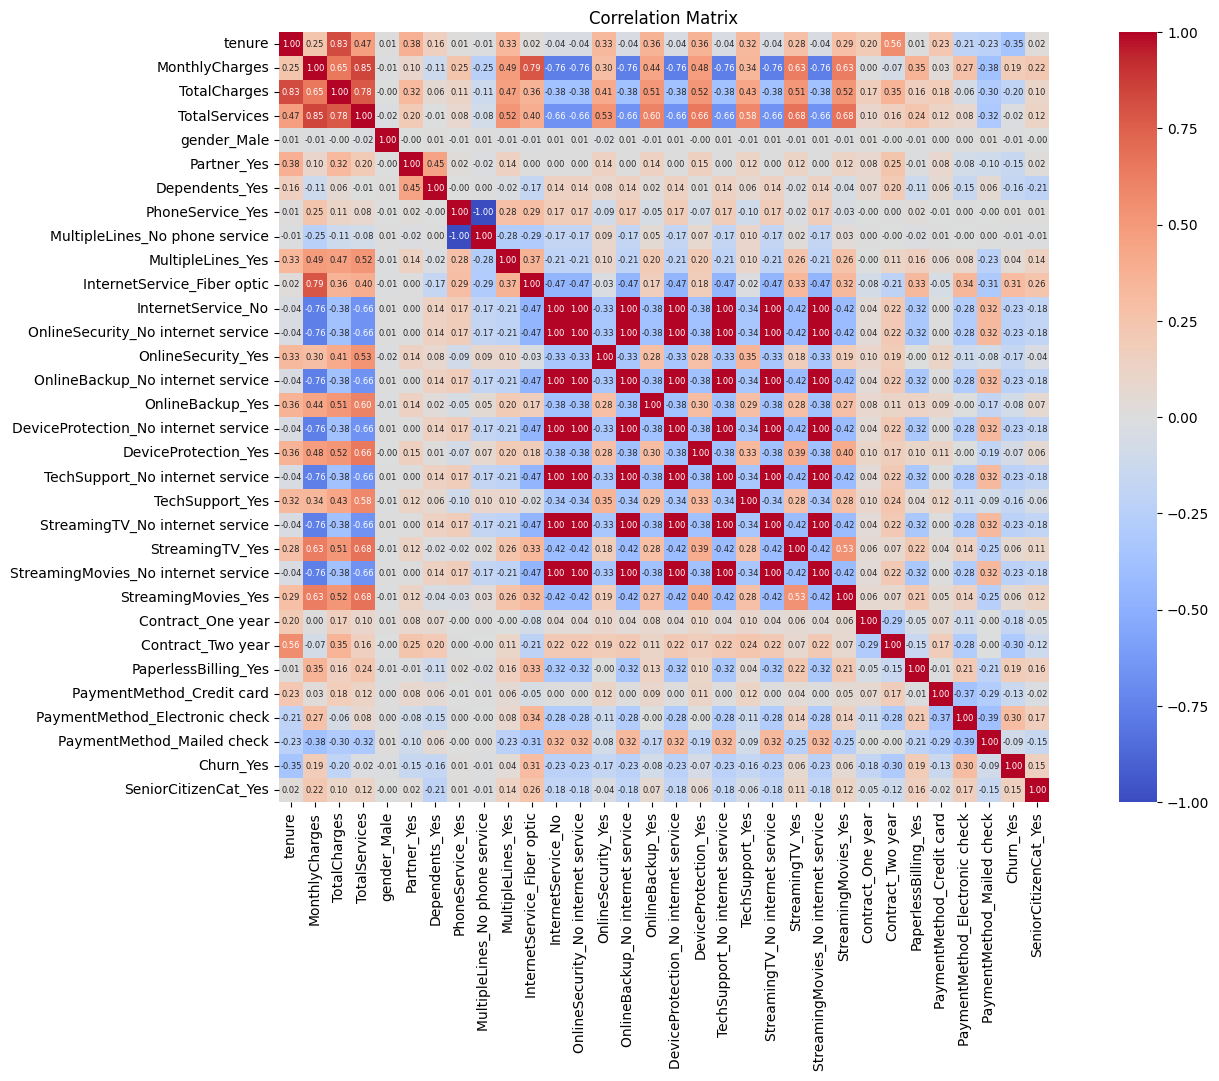

In [47]:
# combine encoded data and encoded label
encode_matrix = pd.get_dummies(eda_data, drop_first=True)

correlation_matrix = encode_matrix.corr()
# visualise correlation
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':6})
plt.title('Correlation Matrix')
plt.show()

### Summary of Correlation
Some key patterns related to customer churn. Churn shows a negative correlation with ContractType (-0.32) and a positive correlation with MonthlyCharges (0.19), suggesting that shorter contracts and higher charges are associated with higher churn. Longer contracts and lower monthly charges are negatively correlated (-0.20).

Interestingly, MonthlyCharges and TotalCharges are predictably correlated (0.65). PaperlessBilling is linked to higher churn (0.19), as are electronic check payments (0.30). Conversely, bank transfer (-0.17) and credit card payments (-0.13) are associated with lower churn. Senior citizens show a slight propensity to churn (0.15), while longer tenure reduces churn likelihood (-0.35). Service features such as PhoneService and StreamingTV have a minimal impact on churn.

### Class Distribution

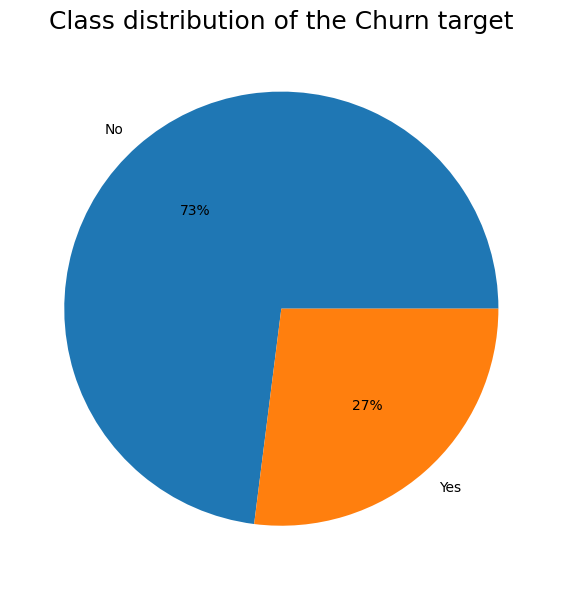

In [48]:
# Class distribution of the Churn target
churn_distribution = eda_data['Churn'].value_counts(normalize=True) * 100 
churn_distribution = churn_distribution.round(0) 
# visualise the distribution
plt.figure(figsize=(10,6))
plt.title('Class distribution of the Churn target', fontsize=18)
plt.pie(churn_distribution, labels=churn_distribution.index, autopct=lambda p: f'{p:.0f}%')
# display the plot
plt.tight_layout()
plt.show()

### Summary of Class Distribution
A pie chart shows that the majority of customers did not churn, accounting for a significant portion of the dataset. Highlighting a class imbalance that needs careful handling in predictive modelling to ensure the minority class (churn) is adequately represented and addressed.

### Feature Engineering (Selection and Extraction) for ML

### Feature Extraction

In [49]:
# extracted a new feature from the contract - define a function to merge one and two-year contracts as long-term and monthly as short-term
def contract_extraction (x):
    if x == 'One year':
        return 'Long Term'
    elif x == 'Two year':
        return 'Long Term'
    else:
        return 'Short Term'
# create a new feature contracttype
cs_data['ContractType'] = cs_data['Contract'].apply(contract_extraction)
cs_data[['ContractType', 'Contract']].head()

ContractType        Contract
0   Short Term  Month-to-month
1    Long Term        One year
2   Short Term  Month-to-month
3    Long Term        One year
4   Short Term  Month-to-month

In [50]:
# Drop the old feature
cs_data.drop('Contract', axis=1, inplace=True)
cs_data.columns

Index(['gender', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'TotalServices', 'SeniorCitizenCat', 'y', 'ContractType'],
      dtype='object')

In [51]:
# select features based on insights from EDA
ml_data = cs_data[['Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService', 
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'ContractType', 
                   'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizenCat']]

ml_data.head()

Partner Dependents  tenure     MultipleLines InternetService OnlineSecurity  \
0     Yes         No       1  No phone service             DSL             No   
1      No         No      34                No             DSL            Yes   
2      No         No       2                No             DSL            Yes   
3      No         No      45  No phone service             DSL            Yes   
4      No         No       2                No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport ContractType PaperlessBilling  \
0          Yes               No          No   Short Term              Yes   
1           No              Yes          No    Long Term               No   
2          Yes               No          No   Short Term              Yes   
3           No              Yes         Yes    Long Term               No   
4           No               No          No   Short Term              Yes   

      PaymentMethod  MonthlyCharges  TotalCharges SeniorCitizenCat  
0  Electronic check           29.85         29.85               No  
1      Mailed check           56.95       1889.50               No  
2      Mailed check           53.85        108.15               No  
3     Bank transfer           42.30       1840.75               No  
4  Electronic check           70.70        151.65               No

### Split Data and Define Preprocessing Pipeline

In [52]:
# Define X and y 
X = ml_data.copy()
y = cs_data['y'].copy()

# ID feature types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

# Numerical Transformation Pipeline
numeric_transformer = Pipeline(steps=[
    # Handle missing numerical values - replacing NaNs with the median of each column
    ("imputer", SimpleImputer(strategy="median")),
    # Apply Quantile Transformation - maps data to a normal distribution
    ("quantile", QuantileTransformer(
        output_distribution="normal",
        random_state=42
    )),
    # Standardise features - scales to mean = 0 and std = 1
    ("scaler", StandardScaler())
])

# Categorical Transformation Pipeline
categorical_transformer = Pipeline(steps=[
    # Handle missing categorical values - replaces NaNs with the most frequent category
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # One-Hot Encode categorical variables - converts categories into binary indicator columns
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both pipelines
preprocess = ColumnTransformer(
    transformers=[
        # Apply numeric pipeline to numeric columns
        ("num", numeric_transformer, numeric_features),
        # Apply categorical pipeline to categorical columns
        ("cat", categorical_transformer, categorical_features),
    ],
    # Drop any columns not specified above
    remainder="drop"
)

numeric_features, categorical_features

(['tenure', 'MonthlyCharges', 'TotalCharges'],
 ['Partner',
  'Dependents',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'ContractType',
  'PaperlessBilling',
  'PaymentMethod',
  'SeniorCitizenCat'])

### Preprocessing Pipeline
ColumnTransformer was used to separately preprocess:
- Numerical Features and Categorical Features
- Median and most frequent imputation
- Quantile transformation (normal output distribution)
- Standard scaling and one-hot encoding

This preprocessing was integrated directly into model pipelines.

### Data Splitting

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
     X, y.squeeze(), 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5634, 15), (5634,), (1409, 15), (1409,))

### Train-Test Split
The dataset was split using 80% training data and 20% testing data with stratified sampling to preserve class balance and a random state set for reproducibility.

All preprocessing and resampling are performed after splitting to avoid leakage.

### Distribution of training data (numeric)

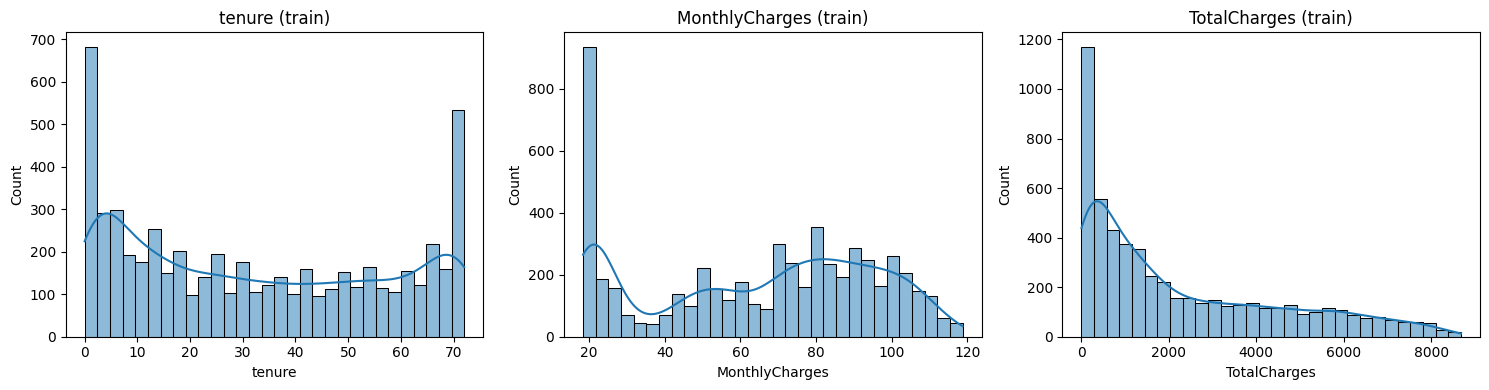

In [54]:
# visualise raw numeric distributions (training data)
fig, axs = plt.subplots(1, len(numeric_features), figsize=(5 * len(numeric_features), 4))
axs = np.atleast_1d(axs)

for ax, col in zip(axs, numeric_features):
    sns.histplot(X_train[col], kde=True, bins=30, ax=ax)
    ax.set_title(f"{col} (train)")

plt.tight_layout()
plt.show()

### Class distribution

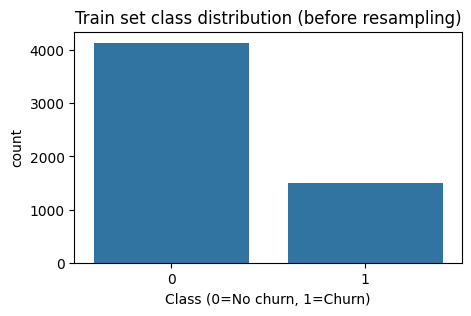

In [57]:
# Class distribution
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(x=y_train, ax=ax)
ax.set_title("Train set class distribution (before resampling)")
ax.set_xlabel("Class (0=No churn, 1=Churn)")
plt.show()

### Model Training & Comparison
The data were trained on the following models
- Logistic Regression (with and without SMOTE)
- Support Vector Classifier
- Gradient Boosting Classifier

Evaluation was performed on the test set using ROC-AUC, Precision, Recall, and F1-score. All models are compared under the same train-test split.

In [58]:
# Base pipeline template
def make_pipeline(model, use_smote=False):
    steps = [("preprocess", preprocess)]
    if use_smote:
        steps.append(("smote", SMOTE(random_state=42)))
    steps.append(("model", model))
    return ImbPipeline(steps=steps)

In [59]:
# Initialise the models
model_pipelines = {
    "Logistic Regression": make_pipeline(
        LogisticRegression(max_iter=3000, random_state=42, class_weight="balanced"),
        use_smote=False
    ),
    "Logistic Regression with SMOTE": make_pipeline(
        LogisticRegression(max_iter=3000, random_state=42),
        use_smote=True
    ),
    "SVC": make_pipeline(
        SVC(probability=True, random_state=42)
    ),
    "Gradient Boosting": make_pipeline(
        GradientBoostingClassifier(random_state=42),
        use_smote=False
    )
}

Logistic Regression
Accuracy: 74.663 %
ROC-AUC (proba): 0.842
PR-AUC  (proba): 0.654
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



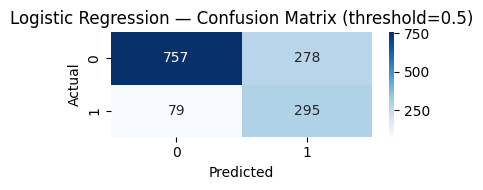

Logistic Regression with SMOTE
Accuracy: 74.450 %
ROC-AUC (proba): 0.841
PR-AUC  (proba): 0.654
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



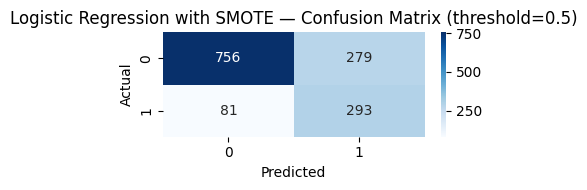

SVC
Accuracy: 80.341 %
ROC-AUC (proba): 0.792
PR-AUC  (proba): 0.628
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1035
           1       0.70      0.46      0.55       374

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



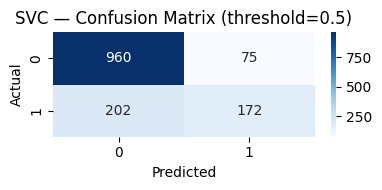

Gradient Boosting
Accuracy: 80.837 %
ROC-AUC (proba): 0.841
PR-AUC  (proba): 0.658
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



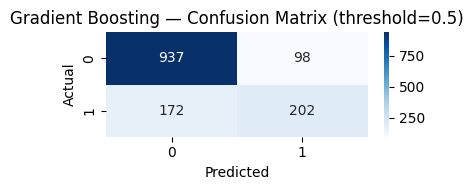

In [60]:
# Train and Evaluate models (use probability-based metrics!)
for name, pipe in model_pipelines.items():
    pipe.fit(X_train, y_train)

    # probabilities for class 1
    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_test)[:, 1]
    else:
        raise ValueError(f"{name} does not support predict_proba")

    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    roc = roc_auc_score(y_test, proba)
    pr = average_precision_score(y_test, proba)

    print("=" * 60)
    print(name)
    print(f"Accuracy: {acc *100:.3f} %")
    print(f"ROC-AUC (proba): {roc:.3f}")
    print(f"PR-AUC  (proba): {pr:.3f}")
    print(classification_report(y_test, pred))

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"{name} — Confusion Matrix (threshold=0.5)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### Model Evaluation
When comparing models for customer churn, the focus is on class 1 (churned customers) because correctly identifying churned customers is often more critical than correctly identifying those who do not churn. 

Logistic Regression without SMOTE emerged as the best model, with the best recall, ROC-AUC, PR-AUC and F1-scores for class 1, indicating its superior ability to identify churned customers and making it the best fit for customer churn analysis.

### Hyperparameter Tuning

In [62]:
# Hyperparameter tuning on full pipeline - Logistic Regression baseline (NO SMOTE)
lr_pipe = make_pipeline(
    LogisticRegression(max_iter=5000, random_state=42),
    use_smote=False
)

param_distributions = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],
    "model__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=lr_pipe,
    param_distributions=param_distributions,
    n_iter=25,
    scoring="average_precision",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_)
print("Best CV PR-AUC:", random_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 0.01}
Best CV PR-AUC: 0.6659683731258502


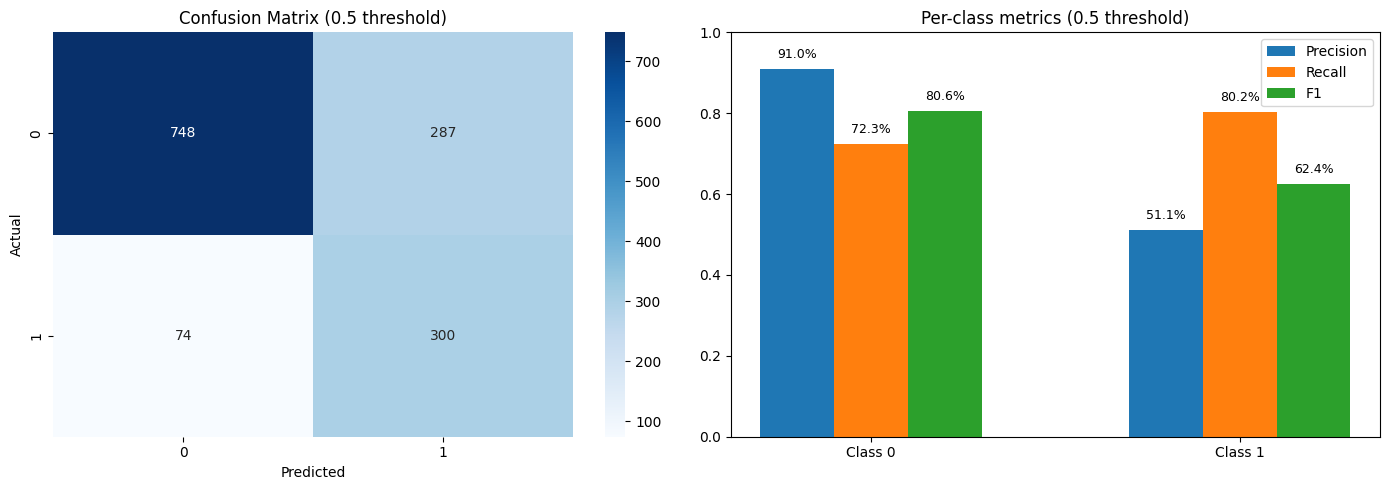

In [63]:
# Evaluate tuned model on test set and visual summaries
proba = best_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, pred)
report = classification_report(y_test, pred, output_dict=True)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, ax=ax[0], annot=True, fmt="d", cmap="Blues")
ax[0].set_title("Confusion Matrix (0.5 threshold)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

labels = ["Class 0", "Class 1"]
precision_vals = [report["0"]["precision"], report["1"]["precision"]]
recall_vals = [report["0"]["recall"], report["1"]["recall"]]
f1_vals = [report["0"]["f1-score"], report["1"]["f1-score"]]

x = np.arange(len(labels))

bars1 = ax[1].bar(x - 0.2, precision_vals, width=0.2, label="Precision")
bars2 = ax[1].bar(x, recall_vals, width=0.2, label="Recall")
bars3 = ax[1].bar(x + 0.2, f1_vals, width=0.2, label="F1")

# Function to add percentage labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax[1].text(
            bar.get_x() + bar.get_width()/2,
            height + 0.02,
            f"{height*100:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylim(0, 1)
ax[1].set_title("Per-class metrics (0.5 threshold)")
ax[1].legend()

plt.tight_layout()
plt.show()

### Hyperparameter Tuning Evaluation Summary
Hyperparameter tuning was performed using RandomizedSearchCV on the Logistic Regression pipeline. The parameters tuned included the regularisation strength (C), solver type, penalty type, and class weighting strategy. Cross-validation was conducted using 5-fold stratified cross-validation, and model selection was based on Precision-Recall AUC (PR-AUC), which is more appropriate for imbalanced classification problems.

After cross-validation, the best-performing model used the following parameters:

- Solver: liblinear
- Penalty: l2
- Class Weight: balanced
- Regularisation Strength (C): 0.01

These settings achieved a best cross-validation PR-AUC score of 0.666 (~ 67%).

For the majority class (class 0), precision was 91%, recall was 72.3%, and the F1 score was 80.6%. For the minority class (class 1), precision was 51.1%, recall was 80.2%, and the F1 score was 62.4%.

The confusion matrix revealed:

- 748 true negatives
- 287 false positives
- 74 false negatives
- 300 true positives

Overall, the model demonstrated strong recall for the minority class, meaning it effectively identified positive cases. However, it produced a relatively high number of false positives, suggesting that while the model is sensitive, it may benefit from threshold tuning or further feature optimisation to improve precision.

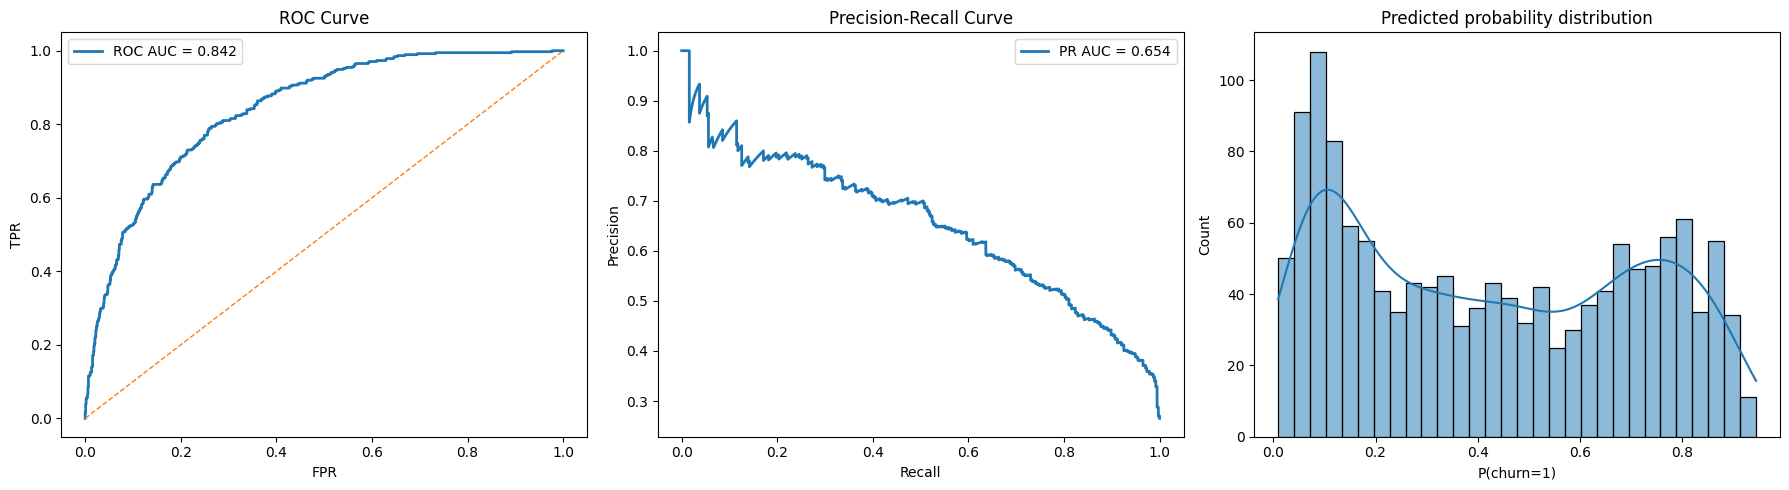

In [68]:
# Curves and probability distribution
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, proba)
pr_auc = average_precision_score(y_test, proba)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.3f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", lw=1)
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].legend()

axes[1].plot(recall, precision, lw=2, label=f"PR AUC = {pr_auc:.3f}")
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()

sns.histplot(proba, kde=True, bins=30, ax=axes[2])
axes[2].set_title("Predicted probability distribution")
axes[2].set_xlabel("P(churn=1)")

plt.tight_layout()
plt.show()

### Threshold tuning

In [70]:
# Threshold selection
out_fold_proba = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

thresholds = np.linspace(0.05, 0.95, 19)
scores = [(t, f1_score(y_train, (out_fold_proba >= t).astype(int))) for t in thresholds]
best_t, best_f1 = max(scores, key=lambda x: x[1])

print(f"Best Threshold from CV on train:: {best_t * 100:.2f}%")
print(f"Out of Fold Best F1 at chosen threshold: {best_f1  * 100:.2f}%")

test_proba = best_model.predict_proba(X_test)[:, 1]
pred_opt = (test_proba >= best_t).astype(int)
print(classification_report(y_test, pred_opt))

Best Threshold from CV on train:: 55.00%
Out of Fold Best F1 at chosen threshold: 63.85%
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



### Model Interpretation

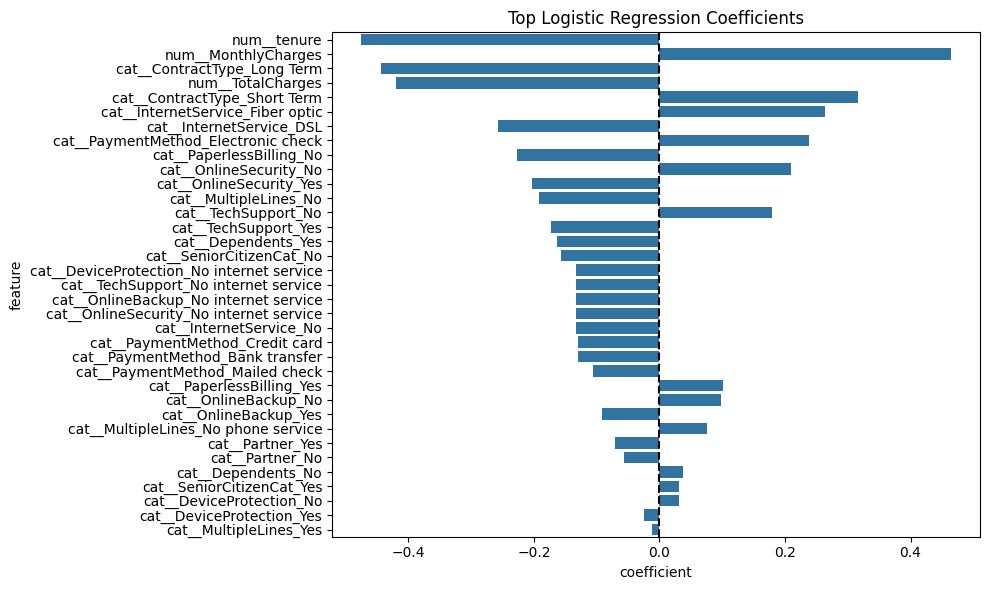

In [66]:
# Feature importance for Logistic Regression
model = best_model.named_steps["model"]
pre = best_model.named_steps["preprocess"]

feature_names = pre.get_feature_names_out()

if hasattr(model, "coef_"):
    importances = model.coef_[0]  # binary classification
    
    fi = pd.DataFrame({
        "feature": feature_names,
        "coefficient": importances,
        "abs_coefficient": np.abs(importances)
    })
    
    fi = fi.sort_values("abs_coefficient", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=fi, x="coefficient", y="feature")
    plt.title("Top Logistic Regression Coefficients")
    plt.axvline(0, color="black", linestyle="--")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not expose coefficients.")

### Save artifacts

In [67]:
# Save full pipeline and metadata

# Create a directory if it does not exist
Path("models").mkdir(exist_ok=True)

# Save model
model_path = "models/churn_pipeline.joblib"
dump(best_model, model_path)

# Save simple metadata
metrics = {
    "test_roc_auc": float(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])),
    "test_pr_auc": float(average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])),
    "best_params": random_search.best_params_,
    "random_state": 42
}

with open("models/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved:", model_path)
print(metrics)

Saved: models/churn_pipeline.joblib
{'test_roc_auc': 0.8420315688857888, 'test_pr_auc': 0.653530813713957, 'best_params': {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 0.01}, 'random_state': 42}


The final tuned Logistic Regression pipeline is saved using joblib.
Evaluation metrics are exported to JSON for documentation and reproducibility.

---

### Ikemefula Solomon ORIAKU
**Location:** London, UK 
**GitHub:** [github.com/gentleiyke](https://github.com/gentleiyke)  
**LinkedIn:** [linkedin.com/in/gentleiyke](https://www.linkedin.com/in/gentleiyke)
